# Prepare Notebook

In [1]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def warn(*args, **kwargs):
    pass
warnings.warn = warn

import numpy as np
import os

from pprint import PrettyPrinter

pp = PrettyPrinter(indent=4)

In [2]:
import sys

sys.path.append("../")

In [3]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=False)

In [4]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def run(line, cell):
    try:
        exec(cell)
    except Exception as e:
        pass

In [5]:
from evaluation.evaluate import evaluate_model, print_eval, plot_diff_train_size_f1
from evaluation.evaluate import CustomGridSearchCV
from sampling.sampling import loc, oversampling_adasyn, oversampling_smote, loc_oversampling_adasyn, loc_oversampling_smote

# Load datasets

In [6]:
dataset_path = "../../datasets/features/"

dataset = np.load(os.path.join(dataset_path, "twitter_bot_dataset_features.npz"))
X = dataset["X"]
y = dataset["y"]
ids = dataset["ids"]

In [7]:
X.shape

(35588, 105)

In [8]:
from features.user import USER_ONLY_FEATURES_IDX

X = X[:,USER_ONLY_FEATURES_IDX]

In [9]:
X.shape

(35588, 36)

In [10]:
classes, classes_freq = np.unique(y, return_counts=True)
list(zip(classes, classes_freq))

[(0, 1083),
 (1, 825),
 (2, 815),
 (3, 80),
 (4, 18431),
 (5, 335),
 (6, 270),
 (7, 4215),
 (8, 7127),
 (9, 2407)]

## Prepare datasets

In [11]:
label_names = [
    "content",
    "fake_follower",
    "feed",
    "game",
    "human",
    "political",
    "service",
    "social_spam",
    "stock",
    "traditional_spam",
]
labels = list(range(len(label_names)))

Remove nan samples

In [12]:
nan_samples = np.isnan(X).any(axis=1)

X = X[~nan_samples]
y = y[~nan_samples]
ids = ids[~nan_samples]

In [13]:
X.shape

(35588, 36)

Dataset distribution after filtering nan values

In [14]:
classes, classes_freq = np.unique(y, return_counts=True)
list(zip(label_names, classes_freq))

[('content', 1083),
 ('fake_follower', 825),
 ('feed', 815),
 ('game', 80),
 ('human', 18431),
 ('political', 335),
 ('service', 270),
 ('social_spam', 4215),
 ('stock', 7127),
 ('traditional_spam', 2407)]

### One hot encode the categorical values

In [15]:
from sklearn.preprocessing import OneHotEncoder
from features.user import USER_FEATURES_INDEX, USER_ONLY_FEATURES

user_features_index = [f for f, i in sorted(USER_FEATURES_INDEX.items(), key=lambda feature: feature[1]) if f in USER_ONLY_FEATURES]

one_hot_enc_username_structures = OneHotEncoder(categories=[list(range(-1,14))])
username_structures_one_hot_enc = one_hot_enc_username_structures.fit_transform(X[:, user_features_index.index("username_structure")].reshape(-1,1))

one_hot_enc_url_other_service_profile = OneHotEncoder(categories=[list(range(13))])
url_other_service_profile_one_hot_enc = one_hot_enc_url_other_service_profile.fit_transform(X[:, user_features_index.index("profile_url_to_other_service_profile")].reshape(-1,1))

del_elems = [
    user_features_index.index("username_structure"),
    user_features_index.index("profile_url_to_other_service_profile")
]

user_features_index = [name for i, name in enumerate(user_features_index) if i not in del_elems]

X = np.delete(X, del_elems, axis=1).reshape((-1, X.shape[1]-len(del_elems)))

binary_features = [
    "description_url_contains_username",
    "description_url_contains_name",
    "description_contains_bot",
    "username_contains_name",
    "username_contains_bot",
    "name_contains_bot",
    "profile_url_domain_contains_username",
    "profile_url_domain_contains_name",
    "profile_url_path_contains_username",
    "profile_url_path_contains_name",
    "default_profile_img",
    "default_profile_background",
    "protected",
    "verified",
    "account_location_provided"
]

continous_features = [f_name for f_name in user_features_index if f_name not in binary_features]

X = np.c_[
    X,
    username_structures_one_hot_enc.toarray(), # 15
    url_other_service_profile_one_hot_enc.toarray(), # 15
]

user_features_index += ["username one hot encoded {}".format(i) for i in range(15)]
user_features_index += ["url to other service profile one hot encoded {}".format(i) for i in range(15)]

print("Shape after one hot encoding: {}".format(X.shape))

Shape after one hot encoding: (35588, 62)


Remove features with variance == 0

In [16]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

vt = VarianceThreshold()
vt.fit(X)
var_threshold_mask = vt.get_support()
X = X[:,var_threshold_mask]

for i, v in enumerate(var_threshold_mask):
    if not v:
        print(i, user_features_index[i])

user_features_index = list(compress(user_features_index, var_threshold_mask))
continous_features = [f_name for f_name in continous_features if f_name in user_features_index]
continous_features_idx = [user_features_index.index(f_name) for f_name in continous_features]

print("Shape after removing features with variance 0: {}".format(X.shape))

51 url to other service profile one hot encoded 2
56 url to other service profile one hot encoded 7
Shape after removing features with variance 0: (35588, 60)


# Dataset exploration

## Plots

In [ ]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_3d = PCA(n_components=3).fit_transform(StandardScaler().fit_transform(X))

plot_data = []
for l in labels:
    Xs = X_3d[y==l]
    plot_data.append(go.Scatter3d(x=Xs[:,0], y=Xs[:,1], z=Xs[:,2], mode="markers", name=label_names[l]))

fig = go.Figure(data=plot_data)
iplot(fig)

In [ ]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_3d = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X))

plot_data = []
for l in labels:
    Xs = X_3d[y==l]
    plot_data.append(go.Scattergl(x=Xs[:,0], y=Xs[:,1], mode="markers", name=label_names[l]))

fig = go.Figure(data=plot_data)
iplot(fig)

## Tables

In [ ]:
import qgrid
import pandas as pd
df = pd.DataFrame(np.c_[y, X])
col_names = ["label"]
col_names += ["{} {}".format(i, name) for i, name in enumerate(USER_FEATURES_INDEX)]
# df.columns = col_names
qgrid.show_grid(df,
                grid_options={
                    'forceFitColumns': False,
                    'defaultColumnWidth': 100
                })

# Classification

## Baseline: Logistic Regression

Best model:
- standard scaler
- F1 Score: 0.457
- ROC AUC: 0.929
- Bot AUC: 0.854
- Bot type AUC: 0.835
- LOG LOSS: 0.676

### Basic

no additional preprocessing

F1 Score (macro): 0.360
ROC AUC (macro): 0.911
Human Bot AUC: 0.891
Bot type AUC (macro): 0.898
LOG LOSS (mean): 0.835
content
	F1 Score (mean): 0.582
	ROC AUC (mean): 0.963
fake_follower
	F1 Score (mean): 0.220
	ROC AUC (mean): 0.947
feed
	F1 Score (mean): 0.128
	ROC AUC (mean): 0.874
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.857
human
	F1 Score (mean): 0.826
	ROC AUC (mean): 0.891
political
	F1 Score (mean): 0.110
	ROC AUC (mean): 0.946
service
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.843
social_spam
	F1 Score (mean): 0.884
	ROC AUC (mean): 0.980
stock
	F1 Score (mean): 0.622
	ROC AUC (mean): 0.919
traditional_spam
	F1 Score (mean): 0.231
	ROC AUC (mean): 0.892


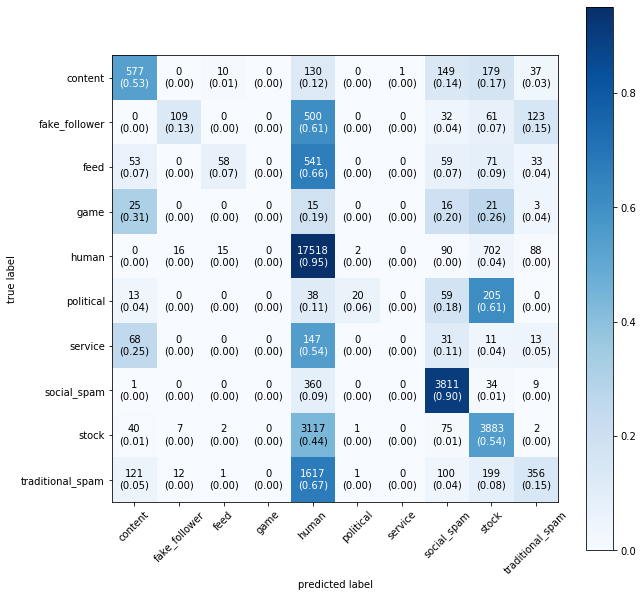

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = LogisticRegression(solver="lbfgs",
                         max_iter=1000,
                         multi_class="ovr",
                         n_jobs=os.cpu_count())

pipeline = Pipeline([("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names, calc_log_loss=True)
print_eval(eval_scores, label_names, console_confm_print=False)

### Data scaling

#### Standard Scaler

F1 Score (macro): 0.457
ROC AUC (macro): 0.929
Human Bot AUC: 0.926
Bot type AUC (macro): 0.933
LOG LOSS (mean): 0.676
content
	F1 Score (mean): 0.726
	ROC AUC (mean): 0.978
fake_follower
	F1 Score (mean): 0.323
	ROC AUC (mean): 0.927
feed
	F1 Score (mean): 0.286
	ROC AUC (mean): 0.923
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.899
human
	F1 Score (mean): 0.869
	ROC AUC (mean): 0.926
political
	F1 Score (mean): 0.127
	ROC AUC (mean): 0.955
service
	F1 Score (mean): 0.050
	ROC AUC (mean): 0.868
social_spam
	F1 Score (mean): 0.889
	ROC AUC (mean): 0.983
stock
	F1 Score (mean): 0.700
	ROC AUC (mean): 0.926
traditional_spam
	F1 Score (mean): 0.598
	ROC AUC (mean): 0.905


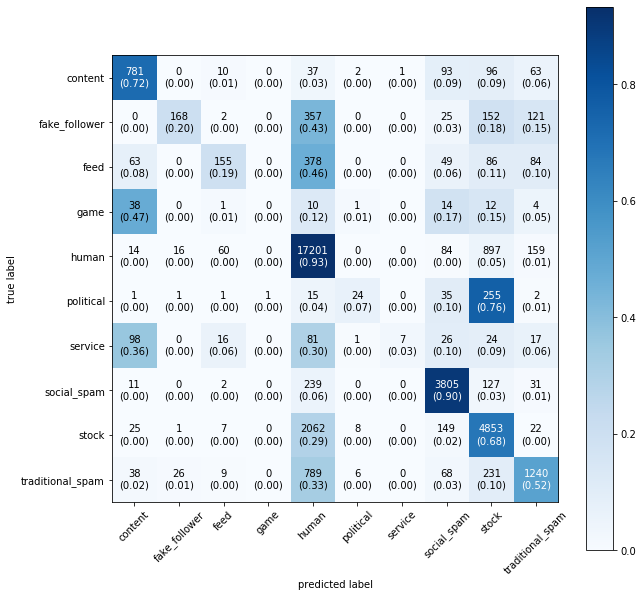

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = LogisticRegression(solver="lbfgs",
                         max_iter=1000,
                         multi_class="ovr",
                         n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names, calc_log_loss=True)
print_eval(eval_scores, label_names, console_confm_print=False)

#### min max scaling:

F1 Score (macro): 0.388
ROC AUC (macro): 0.911
Human Bot AUC: 0.920
Bot type AUC (macro): 0.924
LOG LOSS (mean): 0.753
content
	F1 Score (mean): 0.709
	ROC AUC (mean): 0.978
fake_follower
	F1 Score (mean): 0.155
	ROC AUC (mean): 0.854
feed
	F1 Score (mean): 0.215
	ROC AUC (mean): 0.906
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.917
human
	F1 Score (mean): 0.853
	ROC AUC (mean): 0.920
political
	F1 Score (mean): 0.006
	ROC AUC (mean): 0.955
service
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.860
social_spam
	F1 Score (mean): 0.862
	ROC AUC (mean): 0.976
stock
	F1 Score (mean): 0.639
	ROC AUC (mean): 0.890
traditional_spam
	F1 Score (mean): 0.445
	ROC AUC (mean): 0.858


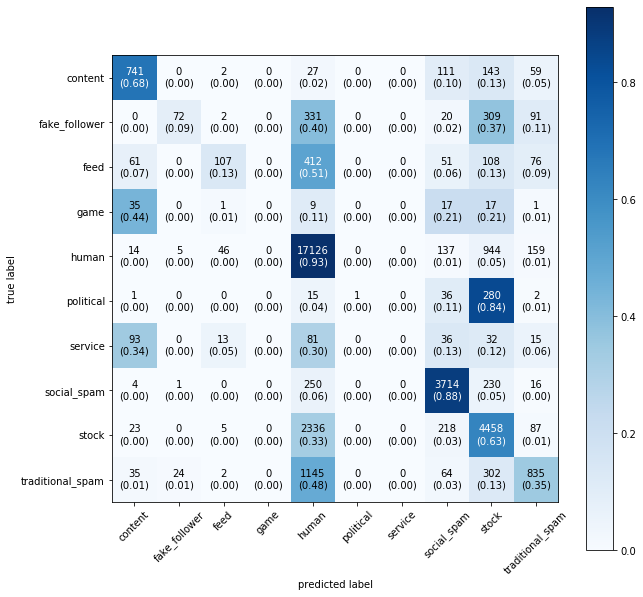

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

clf = LogisticRegression(solver="lbfgs",
                         max_iter=1000,
                         multi_class="ovr",
                         n_jobs=os.cpu_count())
        
pipeline = Pipeline([("scaling", MinMaxScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names, calc_log_loss=True)
print_eval(eval_scores, label_names, console_confm_print=False)

### different train sizes

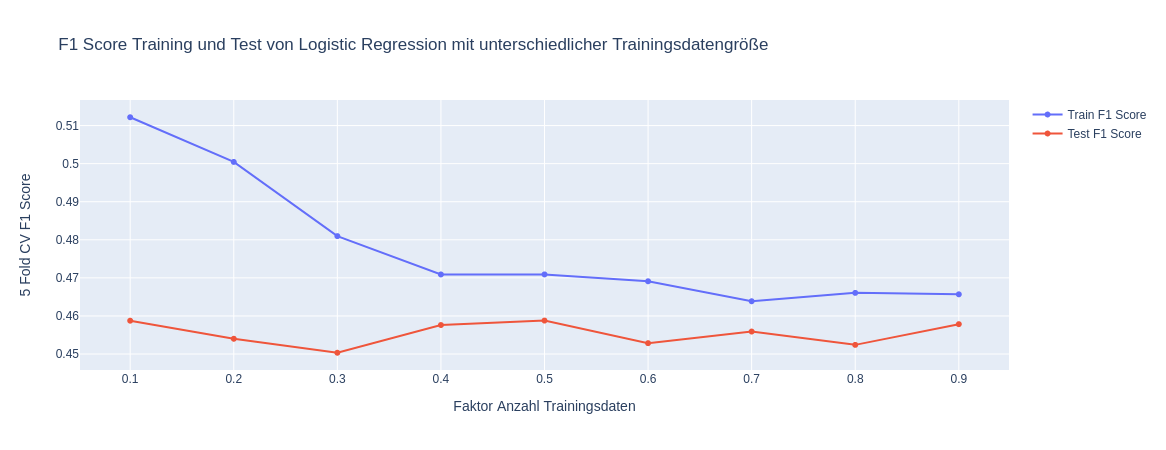

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

clf = LogisticRegression(solver="lbfgs",
                         max_iter=1000,
                         multi_class="ovr",
                         n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "Logistic Regression")

## KNN

Best model:
- smote
- F1 Score: 0.650
- ROC AUC: 0.888
- Bot AUC: 0.920
- Bot type AUC: 0.908

### Basic

Grid Search on basic KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

param_grid = {
    "clf__n_neighbors": range(1,100,1)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

{   'mean_fit_time': array([0.2761199 , 0.29487886, 0.42907515, 0.34810176, 0.37289596,
       0.34942317, 0.30045109, 0.35349379, 0.40191875, 0.41871543,
       0.35467224, 0.34686112, 0.38879409, 0.3434227 , 0.36155558,
       0.40453844, 0.38899617, 0.43081665, 0.38201909, 0.33270054,
       0.39633498, 0.43804893, 0.4009944 , 0.43199167, 0.39484286,
       0.39177365, 0.37433324, 0.44561   , 0.4583529 , 0.38610439,
       0.35283232, 0.46752257, 0.39485803, 0.37084475, 0.36855283,
       0.47280378, 0.39889436, 0.47165389, 0.46124668, 0.38683662,
       0.42461548, 0.36106877, 0.40560808, 0.41951575, 0.46068525,
       0.50518603, 0.39485168, 0.44285669, 0.38291473, 0.39545488,
       0.47095442, 0.38961825, 0.47117643, 0.26899943, 0.55563626,
       0.50460472, 0.49842138, 0.4204186 , 0.4395103 , 0.42749543,
       0.46535416, 0.58332167, 0.51149254, 0.42054029, 0.60769148,
       0.53769884, 0.50635228, 1.04858489, 1.14806356, 1.22734776,
       1.35890999, 1.24353456, 1.25658369

- k: 4
- f1: 0.635

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

param_grid = {
    "clf__n_neighbors": range(1,30)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

- k: 4
- f1: 0.6457

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(metric="minkowski", p=3, n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

param_grid = {
    "clf__n_neighbors": range(1,30)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

- k: 4
- f1: 0.63

best:
- k: 4
- dist metric: manhattan

F1 Score (macro): 0.646
ROC AUC (macro): 0.865
Human Bot AUC: 0.959
Bot type AUC (macro): 0.945
content
	F1 Score (mean): 0.699
	ROC AUC (mean): 0.926
fake_follower
	F1 Score (mean): 0.775
	ROC AUC (mean): 0.919
feed
	F1 Score (mean): 0.355
	ROC AUC (mean): 0.776
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.566
human
	F1 Score (mean): 0.923
	ROC AUC (mean): 0.959
political
	F1 Score (mean): 0.714
	ROC AUC (mean): 0.897
service
	F1 Score (mean): 0.276
	ROC AUC (mean): 0.694
social_spam
	F1 Score (mean): 0.968
	ROC AUC (mean): 0.987
stock
	F1 Score (mean): 0.905
	ROC AUC (mean): 0.969
traditional_spam
	F1 Score (mean): 0.842
	ROC AUC (mean): 0.959


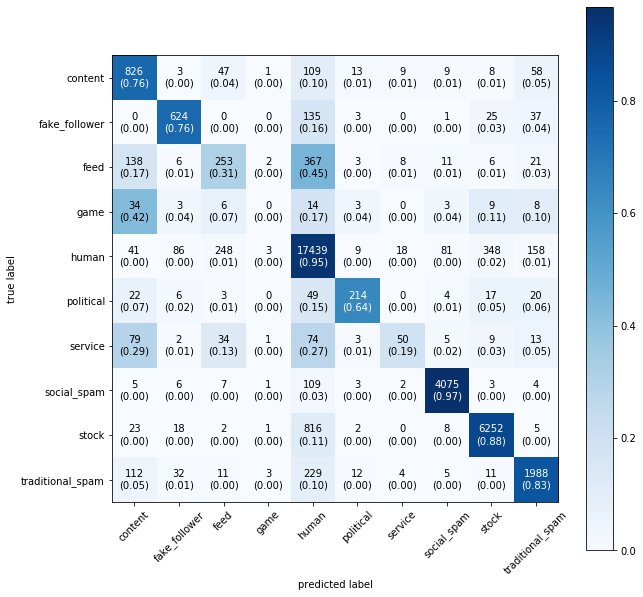

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(n_neighbors=4, metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### Data scaling

scaling provides worse results

#### Standard Scaler

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

estimator_params = {
    "clf__n_neighbors": list(range(1,11,1))
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 10
10/10 (avg 227.42s/job)0.5871068974927959
({'clf__n_neighbors': 5}, {})
{   'bot_aucs': [   0.8617589210452374,
                    0.8603540320314695,
                    0.8567013205956729,
                    0.8696079808908248,
                    0.8519038920893635],
    'bot_type_aucs': [   0.8508007867378478,
                         0.849255408822703,
                         0.8467266085979208,
                         0.8586483068708726,
                         0.8412252353519741],
    'class_scores': {   'content': {   'f1_scores': [   0.7511520737327188,
                                                        0.745920745920746,
                                                        0.7644444444444445,
                                                        0.7533632286995515,
                                                        0.7858719646799117],
                                       'roc_aucs': [   0.9049222813497275,
                            

best k=5

F1 Score (macro): 0.587
ROC AUC (macro): 0.835
Human Bot AUC: 0.920
Bot type AUC (macro): 0.918
content
	F1 Score (mean): 0.760
	ROC AUC (mean): 0.925
fake_follower
	F1 Score (mean): 0.370
	ROC AUC (mean): 0.749
feed
	F1 Score (mean): 0.477
	ROC AUC (mean): 0.832
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.534
human
	F1 Score (mean): 0.871
	ROC AUC (mean): 0.920
political
	F1 Score (mean): 0.586
	ROC AUC (mean): 0.868
service
	F1 Score (mean): 0.367
	ROC AUC (mean): 0.736
social_spam
	F1 Score (mean): 0.944
	ROC AUC (mean): 0.980
stock
	F1 Score (mean): 0.702
	ROC AUC (mean): 0.895
traditional_spam
	F1 Score (mean): 0.793
	ROC AUC (mean): 0.908


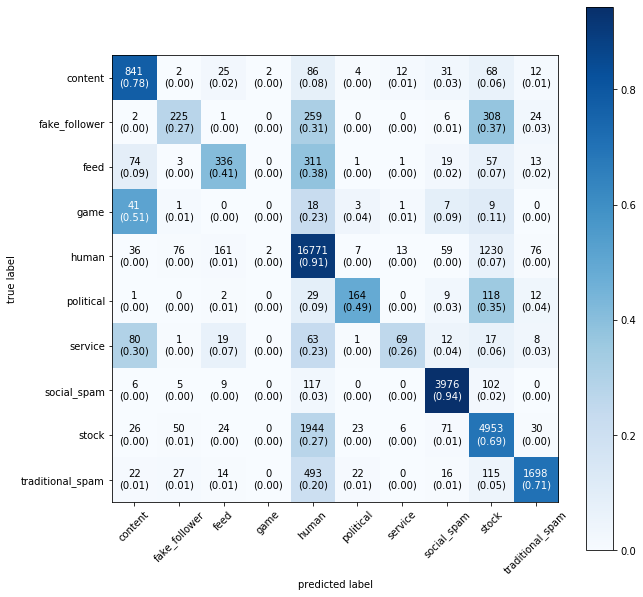

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(n_neighbors=5, metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### min max scaling

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", MinMaxScaler()), ("clf", clf)])

estimator_params = {
    "clf__n_neighbors": list(range(1,30,1))
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

best k=4

F1 Score (macro): 0.566
ROC AUC (macro): 0.817
Human Bot AUC: 0.908
Bot type AUC (macro): 0.903
content
	F1 Score (mean): 0.709
	ROC AUC (mean): 0.912
fake_follower
	F1 Score (mean): 0.295
	ROC AUC (mean): 0.703
feed
	F1 Score (mean): 0.435
	ROC AUC (mean): 0.797
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.535
human
	F1 Score (mean): 0.862
	ROC AUC (mean): 0.908
political
	F1 Score (mean): 0.654
	ROC AUC (mean): 0.863
service
	F1 Score (mean): 0.356
	ROC AUC (mean): 0.717
social_spam
	F1 Score (mean): 0.921
	ROC AUC (mean): 0.974
stock
	F1 Score (mean): 0.651
	ROC AUC (mean): 0.866
traditional_spam
	F1 Score (mean): 0.781
	ROC AUC (mean): 0.892


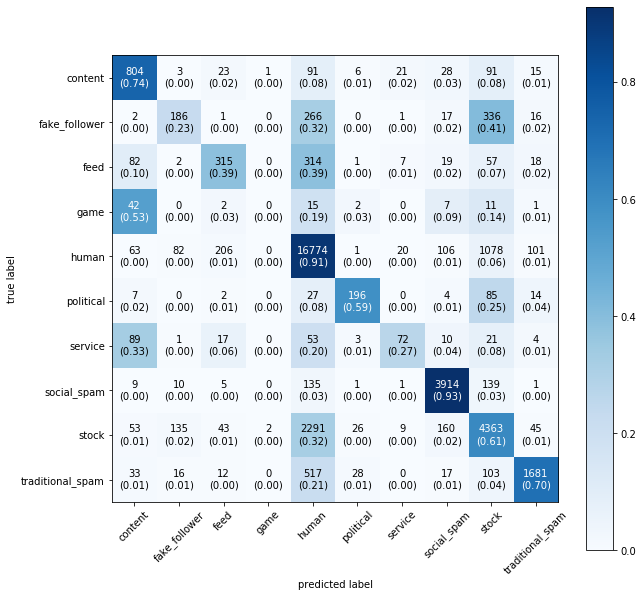

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

clf = KNeighborsClassifier(n_neighbors=4, metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("scaling", MinMaxScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### PCA

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

        
pipeline = Pipeline([("pca", PCA()), ("clf", clf)])

param_grid = {
    "pca__n_components": range(45, 55, 1),
    "clf__n_neighbors": range(1, 10, 1)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), verbose=1, param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

#pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   20.6s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 450 out of 450 | elapsed:  4.1min finished


{'clf__n_neighbors': 8, 'pca__n_components': 46}
0.6443783023061105


F1 Score (macro): 0.644
ROC AUC (macro): 0.890
Human Bot AUC: 0.966
Bot type AUC (macro): 0.959
content
	F1 Score (mean): 0.715
	ROC AUC (mean): 0.947
fake_follower
	F1 Score (mean): 0.778
	ROC AUC (mean): 0.936
feed
	F1 Score (mean): 0.334
	ROC AUC (mean): 0.841
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.625
human
	F1 Score (mean): 0.926
	ROC AUC (mean): 0.966
political
	F1 Score (mean): 0.704
	ROC AUC (mean): 0.926
service
	F1 Score (mean): 0.275
	ROC AUC (mean): 0.730
social_spam
	F1 Score (mean): 0.966
	ROC AUC (mean): 0.989
stock
	F1 Score (mean): 0.907
	ROC AUC (mean): 0.976
traditional_spam
	F1 Score (mean): 0.839
	ROC AUC (mean): 0.965


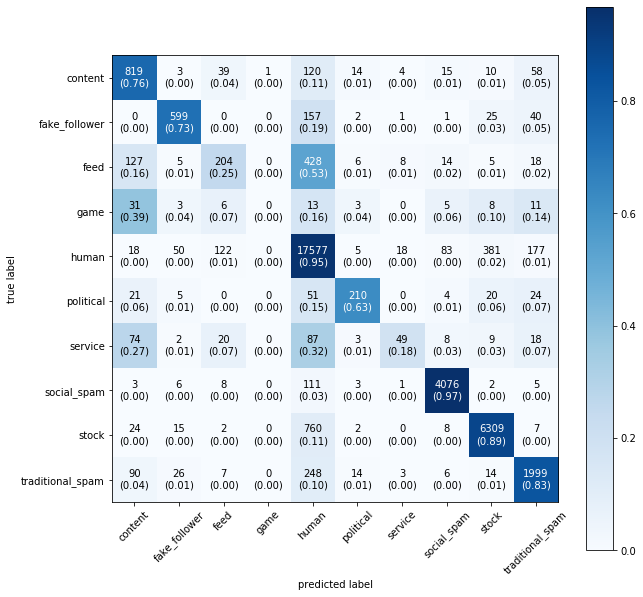

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

clf = KNeighborsClassifier(n_neighbors=8, metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("pca", PCA(n_components=46)), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### Scaling + PCA

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

        
pipeline = Pipeline([("scaling", StandardScaler()), ("pca", PCA()), ("clf", clf)])

param_grid = {
    "pca__n_components": range(20, 41, 1),
    "clf__n_neighbors": range(2, 8, 1)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), verbose=1, param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

#pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 630 out of 630 | elapsed: 31.5min finished


{'clf__n_neighbors': 5, 'pca__n_components': 38}
0.5590963393330167


F1 Score (macro): 0.554
ROC AUC (macro): 0.822
Human Bot AUC: 0.910
Bot type AUC (macro): 0.907
content
	F1 Score (mean): 0.726
	ROC AUC (mean): 0.917
fake_follower
	F1 Score (mean): 0.314
	ROC AUC (mean): 0.722
feed
	F1 Score (mean): 0.449
	ROC AUC (mean): 0.820
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.552
human
	F1 Score (mean): 0.861
	ROC AUC (mean): 0.910
political
	F1 Score (mean): 0.455
	ROC AUC (mean): 0.825
service
	F1 Score (mean): 0.356
	ROC AUC (mean): 0.732
social_spam
	F1 Score (mean): 0.935
	ROC AUC (mean): 0.978
stock
	F1 Score (mean): 0.670
	ROC AUC (mean): 0.873
traditional_spam
	F1 Score (mean): 0.774
	ROC AUC (mean): 0.894


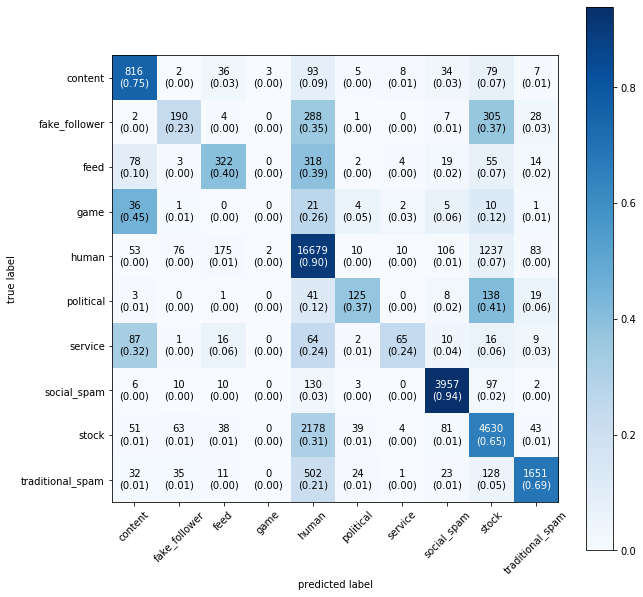

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clf = KNeighborsClassifier(n_neighbors=5, metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("pca", PCA(n_components=38)), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### oversampling game class

#### adasyn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("clf", clf)])

estimator_params = {
    "clf__n_neighbors": list(range(1,100,1)),
}

train_preproc_params = {
    "n_neighbors": list(range(1,100,1)),
    "sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names, train_preproc_func=oversampling_adasyn, train_preproc_params=train_preproc_params)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

best:
 - knn:
  - n_neighbors: 6
 - smote:
  - k_neighbors: 31
  - sampling_strategy: 3:800

F1 Score (macro): 0.648
ROC AUC (macro): 0.890
Human Bot AUC: 0.964
Bot type AUC (macro): 0.955
content
	F1 Score (mean): 0.680
	ROC AUC (mean): 0.927
fake_follower
	F1 Score (mean): 0.784
	ROC AUC (mean): 0.931
feed
	F1 Score (mean): 0.327
	ROC AUC (mean): 0.804
game
	F1 Score (mean): 0.081
	ROC AUC (mean): 0.740
human
	F1 Score (mean): 0.925
	ROC AUC (mean): 0.964
political
	F1 Score (mean): 0.697
	ROC AUC (mean): 0.906
service
	F1 Score (mean): 0.263
	ROC AUC (mean): 0.705
social_spam
	F1 Score (mean): 0.968
	ROC AUC (mean): 0.988
stock
	F1 Score (mean): 0.908
	ROC AUC (mean): 0.974
traditional_spam
	F1 Score (mean): 0.845
	ROC AUC (mean): 0.962


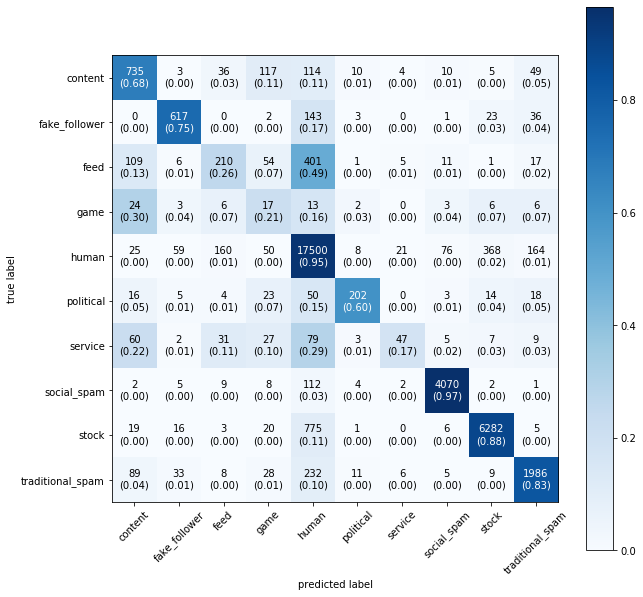

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

clf = KNeighborsClassifier(n_neighbors=6, metric="manhattan", n_jobs=os.cpu_count())

adasyn = ADASYN(sampling_strategy={3:800}, n_neighbors=31, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("adasyn", adasyn), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### smote

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("clf", clf)])

estimator_params = {
    "clf__n_neighbors": list(range(1,10,1)),
}

train_preproc_params = {
    "k_neighbors": list(range(10,31,1)),
    "sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names, train_preproc_func=oversampling_smote, train_preproc_params=train_preproc_params)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
#pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 189
189/189 (avg 11.97s/job)0.6504538451981592
({'clf__n_neighbors': 6}, {'k_neighbors': 12, 'sampling_strategy': {3: 800}})


Process GridSearchWatch-8:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "../evaluation/evaluate.py", line 274, in run
    worker_time = self.worker_times_q.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


best:
 - knn:
  - n_neighbors: 6
 - smote:
  - k_neighbors: 12
  - sampling_strategy: 3:800

F1 Score (macro): 0.650
ROC AUC (macro): 0.888
Human Bot AUC: 0.964
Bot type AUC (macro): 0.954
content
	F1 Score (mean): 0.684
	ROC AUC (mean): 0.927
fake_follower
	F1 Score (mean): 0.782
	ROC AUC (mean): 0.931
feed
	F1 Score (mean): 0.330
	ROC AUC (mean): 0.803
game
	F1 Score (mean): 0.098
	ROC AUC (mean): 0.711
human
	F1 Score (mean): 0.925
	ROC AUC (mean): 0.964
political
	F1 Score (mean): 0.692
	ROC AUC (mean): 0.909
service
	F1 Score (mean): 0.273
	ROC AUC (mean): 0.709
social_spam
	F1 Score (mean): 0.968
	ROC AUC (mean): 0.988
stock
	F1 Score (mean): 0.907
	ROC AUC (mean): 0.974
traditional_spam
	F1 Score (mean): 0.844
	ROC AUC (mean): 0.962


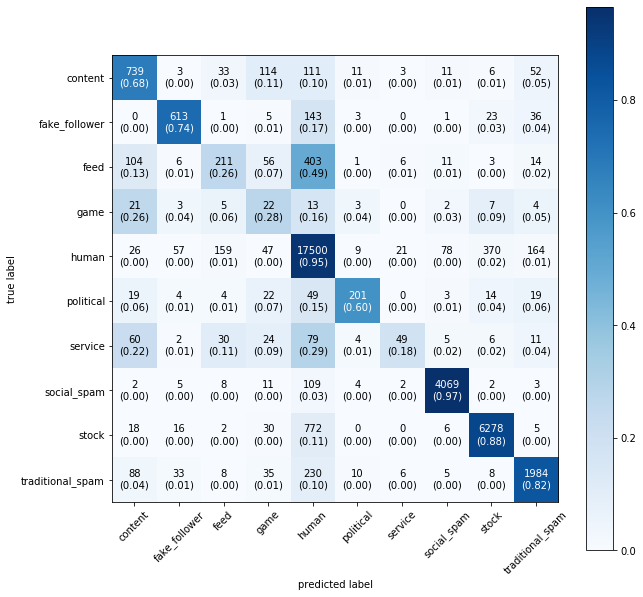

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

clf = KNeighborsClassifier(n_neighbors=6, metric="manhattan", n_jobs=os.cpu_count())

smote = SMOTE(sampling_strategy={3:800}, k_neighbors=12, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("smote", smote), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### different train sizes

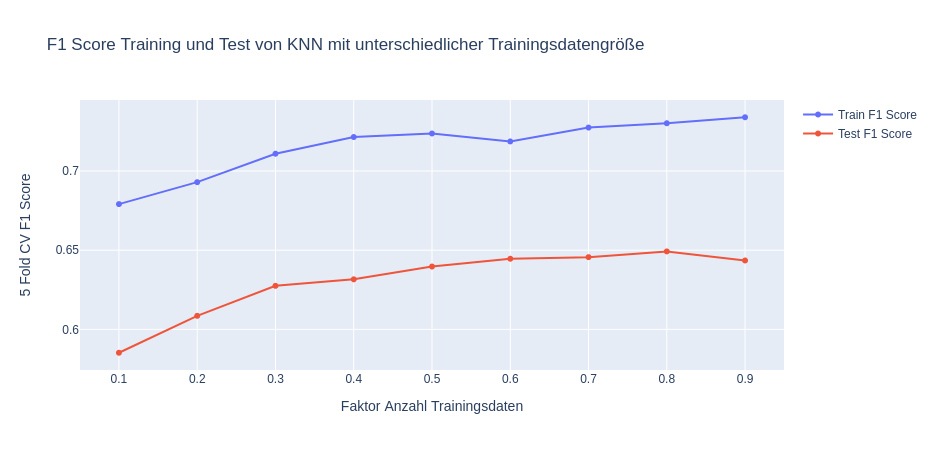

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(n_neighbors=4, metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "KNN")

## BNB

Best model:
 - smote + sklearn quantile binning
 - F1 Score: 0.625
 - ROC AUC: 0.970
 - Bot AUC: 0.874
 - Bot type AUC: 0.864

### binning + var threshold

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer

clf = BernoulliNB()
pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot"), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])
 
param_grid = {
    "feature_binning__binning__n_bins": range(30,40,1),
    "feature_binning__binning__strategy": ["quantile"]
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, verbose=1, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

# pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.9s


{   'feature_binning__binning__n_bins': 34,
    'feature_binning__binning__strategy': 'quantile'}
0.6234253030642136


[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    2.3s finished
/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preproce

F1 Score (macro): 0.623
ROC AUC (macro): 0.970
Human Bot AUC: 0.948
Bot type AUC (macro): 0.962
content
	F1 Score (mean): 0.780
	ROC AUC (mean): 0.991
fake_follower
	F1 Score (mean): 0.513
	ROC AUC (mean): 0.975
feed
	F1 Score (mean): 0.428
	ROC AUC (mean): 0.959
game
	F1 Score (mean): 0.156
	ROC AUC (mean): 0.946
human
	F1 Score (mean): 0.870
	ROC AUC (mean): 0.948
political
	F1 Score (mean): 0.682
	ROC AUC (mean): 0.980
service
	F1 Score (mean): 0.307
	ROC AUC (mean): 0.965
social_spam
	F1 Score (mean): 0.918
	ROC AUC (mean): 0.992
stock
	F1 Score (mean): 0.890
	ROC AUC (mean): 0.981
traditional_spam
	F1 Score (mean): 0.691
	ROC AUC (mean): 0.961


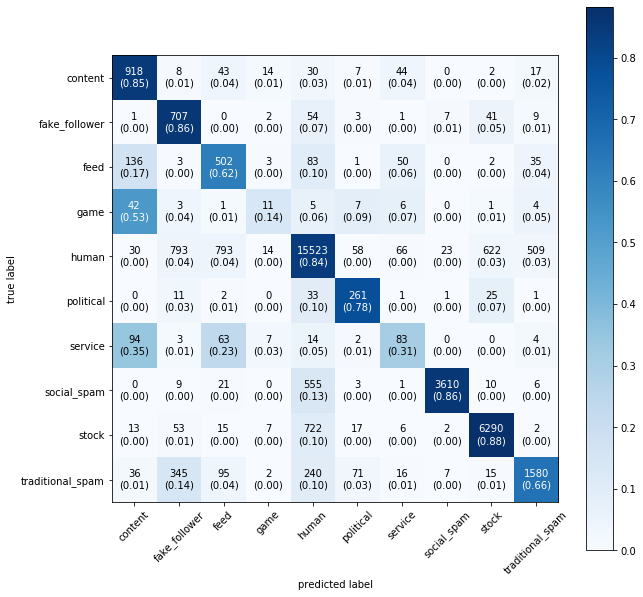

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

clf = BernoulliNB()

pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="quantile", n_bins=34), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### binning + var threshold + chi2

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer

clf = BernoulliNB()
pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot"), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ('feature_selection', SelectKBest(score_func=chi2)),
    ("clf", clf)])
 
param_grid = {
    "feature_binning__binning__n_bins": range(15,18,1),
    "feature_binning__binning__strategy": ["kmeans"],
    "feature_selection__k": range(20,61,1)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, verbose=1, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

Fitting 5 folds for each of 123 candidates, totalling 615 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   40.3s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 615 out of 615 | elapsed: 11.4min finished
/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:184: ConvergenceWarning:

Number of distinct clusters (12) found smaller than n_clusters (17). Possibly due to duplicate points in X.

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discr

{   'mean_fit_time': array([5.38946218, 5.60034156, 5.9081409 , 5.53216472, 5.7918963 ,
       5.88998599, 5.58471317, 5.52883511, 5.82858372, 5.68032827,
       5.76798272, 5.86845965, 6.07012563, 5.92073536, 5.84265428,
       5.52552705, 6.05109839, 5.84674616, 5.29608274, 5.91720481,
       5.78116236, 5.70682631, 5.84803767, 5.66546793, 5.80559816,
       5.83435969, 5.6999362 , 5.57217007, 5.74167433, 5.75022912,
       5.83367333, 5.92643585, 5.69302368, 5.77518849, 5.5838809 ,
       5.69928064, 5.69724021, 5.69207416, 5.8735714 , 5.63025627,
       5.70935297, 6.31213384, 6.17252021, 6.28492069, 6.26492891,
       6.34957128, 6.49312239, 6.26017175, 6.43353415, 6.19497147,
       6.29297147, 6.32228932, 6.34486303, 6.47760434, 6.24671445,
       6.23899565, 6.3611589 , 6.25845456, 5.53007898, 5.85792346,
       5.8578331 , 5.83975334, 5.83283257, 5.63396235, 5.49842968,
       5.80310054, 6.16827536, 6.63571773, 6.83363128, 7.04239841,
       6.54953771, 6.36161518, 6.45427675

F1 Score (macro): 0.568
ROC AUC (macro): 0.957
Human Bot AUC: 0.945
Bot type AUC (macro): 0.955
content
	F1 Score (mean): 0.758
	ROC AUC (mean): 0.989
fake_follower
	F1 Score (mean): 0.463
	ROC AUC (mean): 0.963
feed
	F1 Score (mean): 0.418
	ROC AUC (mean): 0.933
game
	F1 Score (mean): 0.064
	ROC AUC (mean): 0.944
human
	F1 Score (mean): 0.872
	ROC AUC (mean): 0.945
political
	F1 Score (mean): 0.633
	ROC AUC (mean): 0.975
service
	F1 Score (mean): 0.113
	ROC AUC (mean): 0.935
social_spam
	F1 Score (mean): 0.910
	ROC AUC (mean): 0.988
stock
	F1 Score (mean): 0.823
	ROC AUC (mean): 0.966
traditional_spam
	F1 Score (mean): 0.624
	ROC AUC (mean): 0.930


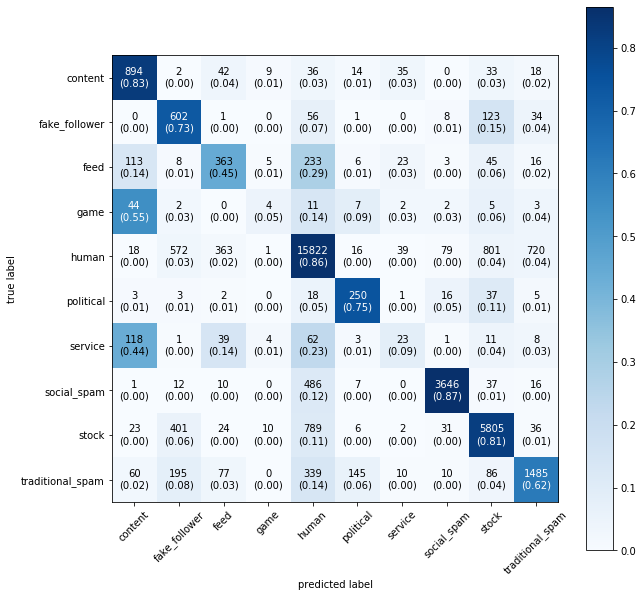

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2

clf = BernoulliNB()

pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="kmeans", n_bins=17), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("feature_selection", SelectKBest(chi2, k=56)),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### custom binning

F1 Score (macro): 0.613
ROC AUC (macro): 0.967
Human Bot AUC: 0.945
Bot type AUC (macro): 0.961
content
	F1 Score (mean): 0.787
	ROC AUC (mean): 0.992
fake_follower
	F1 Score (mean): 0.524
	ROC AUC (mean): 0.974
feed
	F1 Score (mean): 0.418
	ROC AUC (mean): 0.952
game
	F1 Score (mean): 0.152
	ROC AUC (mean): 0.947
human
	F1 Score (mean): 0.865
	ROC AUC (mean): 0.945
political
	F1 Score (mean): 0.587
	ROC AUC (mean): 0.978
service
	F1 Score (mean): 0.338
	ROC AUC (mean): 0.962
social_spam
	F1 Score (mean): 0.914
	ROC AUC (mean): 0.990
stock
	F1 Score (mean): 0.881
	ROC AUC (mean): 0.978
traditional_spam
	F1 Score (mean): 0.660
	ROC AUC (mean): 0.955


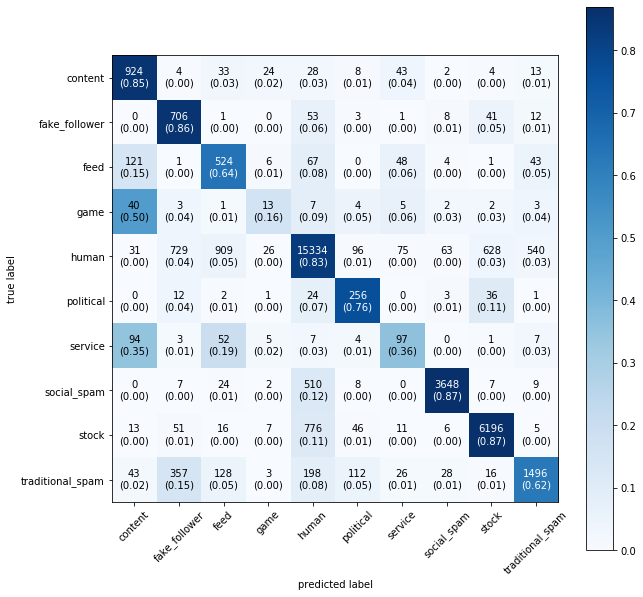

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

percentiles = [
    99.9,
    95,
    90,
    85,
    80,
    75,
    70,
    65,
    60,
    55,
    54,
    53,
    52,
    51,
    50,
    49,
    48,
    47,
    46,
    45,
    40,
    35,
    30,
    25,
    20,
    15,
    10,
    5,
    0.01
]

def custom_column_transformer(X):
    X_new = np.empty_like(X)
    for i in range(X.shape[1]):
        bins = [np.percentile(X[:,i], p) for p in percentiles]
        binned = np.digitize(X[:,i], bins, right=False)
        X_new[:,i] = binned

    return X_new


clf = BernoulliNB()

ct = ColumnTransformer(
        transformers=[
            ("binning", FunctionTransformer(func=custom_column_transformer), continous_features_idx),
        ],
        remainder="passthrough",
        n_jobs=os.cpu_count())

X_new = ct.fit_transform(X)
X_new = OneHotEncoder(sparse=False).fit_transform(X_new)
X_new = VarianceThreshold().fit_transform(X_new)

eval_scores = evaluate_model(clf, X_new, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### select k best chi square

F1 Score (macro): 0.346
ROC AUC (macro): 0.851
Human Bot AUC: 0.762
Bot type AUC (macro): 0.798
content
	F1 Score (mean): 0.161
	ROC AUC (mean): 0.877
fake_follower
	F1 Score (mean): 0.658
	ROC AUC (mean): 0.913
feed
	F1 Score (mean): 0.212
	ROC AUC (mean): 0.818
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.832
human
	F1 Score (mean): 0.776
	ROC AUC (mean): 0.762
political
	F1 Score (mean): 0.011
	ROC AUC (mean): 0.912
service
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.847
social_spam
	F1 Score (mean): 0.638
	ROC AUC (mean): 0.868
stock
	F1 Score (mean): 0.551
	ROC AUC (mean): 0.803
traditional_spam
	F1 Score (mean): 0.455
	ROC AUC (mean): 0.877


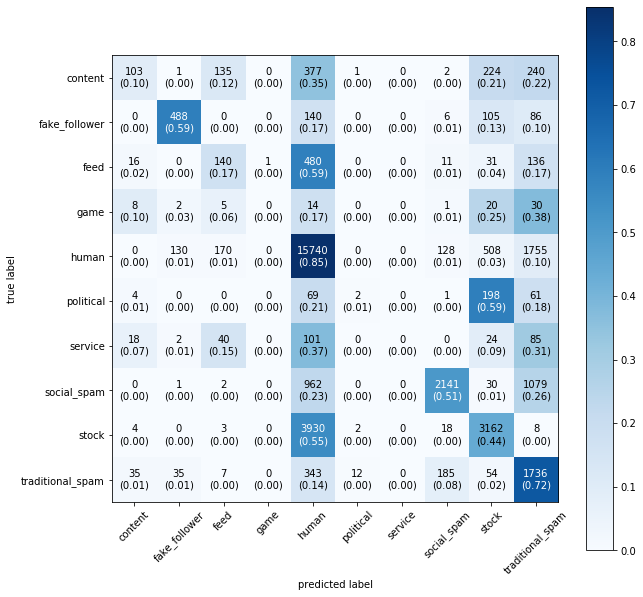

In [32]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

percentiles = [
    99.9,
    95,
    90,
    85,
    80,
    75,
    70,
    65,
    60,
    55,
    50,
    45,
    40,
    35,
    30,
    25,
    20,
    15,
    10,
    5,
    0.01
]

def custom_column_transformer(X):
    X_new = np.empty_like(X)
    for i in range(X.shape[1]):
        bins = [np.percentile(X[:,i], p) for p in percentiles]
        binned = np.digitize(X[:,i], bins, right=False)
        X_new[:,i] = binned

    return X_new


clf = BernoulliNB()

ct = ColumnTransformer(
        transformers=[
            ("binning", FunctionTransformer(func=custom_column_transformer), continous_features_idx),
        ],
        remainder="passthrough",
        n_jobs=os.cpu_count())

X_new = ct.fit_transform(X)
X_new = OneHotEncoder(sparse=False).fit_transform(X_new)
X_new = VarianceThreshold().fit_transform(X_new)
X_new = SelectKBest(score_func=chi2).fit_transform(X_new, y)

eval_scores = evaluate_model(clf, X_new, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### oversampling game class

#### adasyn

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

clf = BernoulliNB()

pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot"), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

estimator_params = {
    "feature_binning__binning__n_bins": range(1,51,1),
    "feature_binning__binning__strategy": ["quantile", "kmeans", "uniform"]
}

train_preproc_params = {
    "n_neighbors": range(1,61,1),
    "sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names, train_preproc_func=oversampling_adasyn, train_preproc_params=train_preproc_params)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

F1 Score (macro): 0.624
ROC AUC (macro): 0.970
Human Bot AUC: 0.949
Bot type AUC (macro): 0.964
content
	F1 Score (mean): 0.756
	ROC AUC (mean): 0.991
fake_follower
	F1 Score (mean): 0.510
	ROC AUC (mean): 0.975
feed
	F1 Score (mean): 0.431
	ROC AUC (mean): 0.957
game
	F1 Score (mean): 0.167
	ROC AUC (mean): 0.945
human
	F1 Score (mean): 0.872
	ROC AUC (mean): 0.949
political
	F1 Score (mean): 0.701
	ROC AUC (mean): 0.980
service
	F1 Score (mean): 0.299
	ROC AUC (mean): 0.964
social_spam
	F1 Score (mean): 0.924
	ROC AUC (mean): 0.992
stock
	F1 Score (mean): 0.888
	ROC AUC (mean): 0.981
traditional_spam
	F1 Score (mean): 0.695
	ROC AUC (mean): 0.962


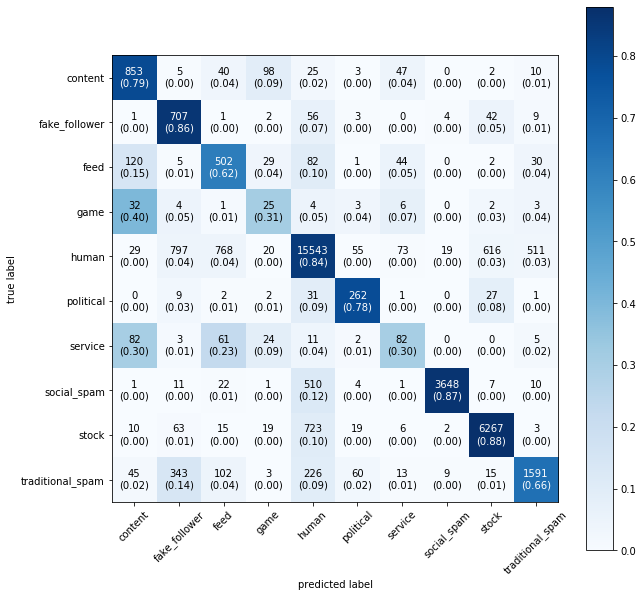

In [33]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

clf = BernoulliNB()

pipeline = Pipeline([
    ("adasyn", ADASYN(sampling_strategy={3:800}, n_neighbors=25, random_state=42, n_jobs=os.cpu_count())),
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="quantile", n_bins=54), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### smote

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

clf = BernoulliNB()

pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot"), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])


estimator_params = {
    "feature_binning__binning__n_bins": range(2,51,1),
    "feature_binning__binning__strategy": ["quantile", "kmeans", "uniform"]
}

train_preproc_params = {
    "k_neighbors": range(1,61,1),
    "sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names, train_preproc_func=oversampling_smote, train_preproc_params=train_preproc_params)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

F1 Score (macro): 0.625
ROC AUC (macro): 0.970
Human Bot AUC: 0.949
Bot type AUC (macro): 0.963
content
	F1 Score (mean): 0.756
	ROC AUC (mean): 0.990
fake_follower
	F1 Score (mean): 0.510
	ROC AUC (mean): 0.975
feed
	F1 Score (mean): 0.433
	ROC AUC (mean): 0.958
game
	F1 Score (mean): 0.148
	ROC AUC (mean): 0.946
human
	F1 Score (mean): 0.874
	ROC AUC (mean): 0.949
political
	F1 Score (mean): 0.697
	ROC AUC (mean): 0.980
service
	F1 Score (mean): 0.323
	ROC AUC (mean): 0.961
social_spam
	F1 Score (mean): 0.925
	ROC AUC (mean): 0.992
stock
	F1 Score (mean): 0.889
	ROC AUC (mean): 0.981
traditional_spam
	F1 Score (mean): 0.697
	ROC AUC (mean): 0.962


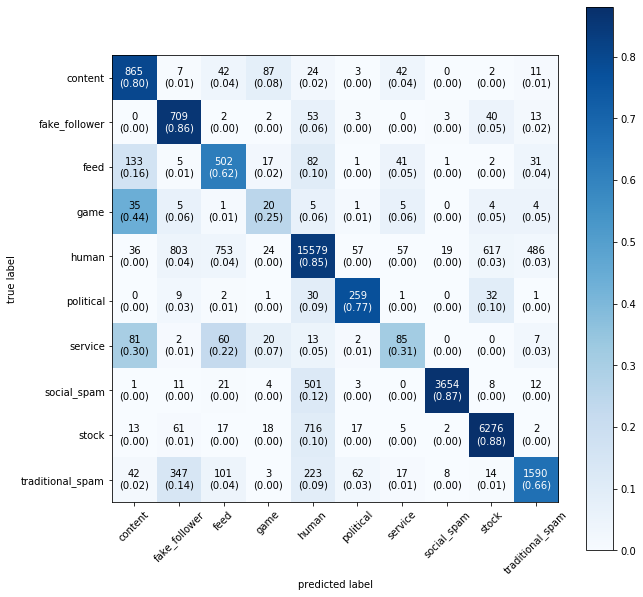

In [34]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

clf = BernoulliNB()

pipeline = Pipeline([
    ("smote", SMOTE(sampling_strategy={3:800}, k_neighbors=4, random_state=42, n_jobs=os.cpu_count())),
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="quantile", n_bins=55), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### different train size

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too s

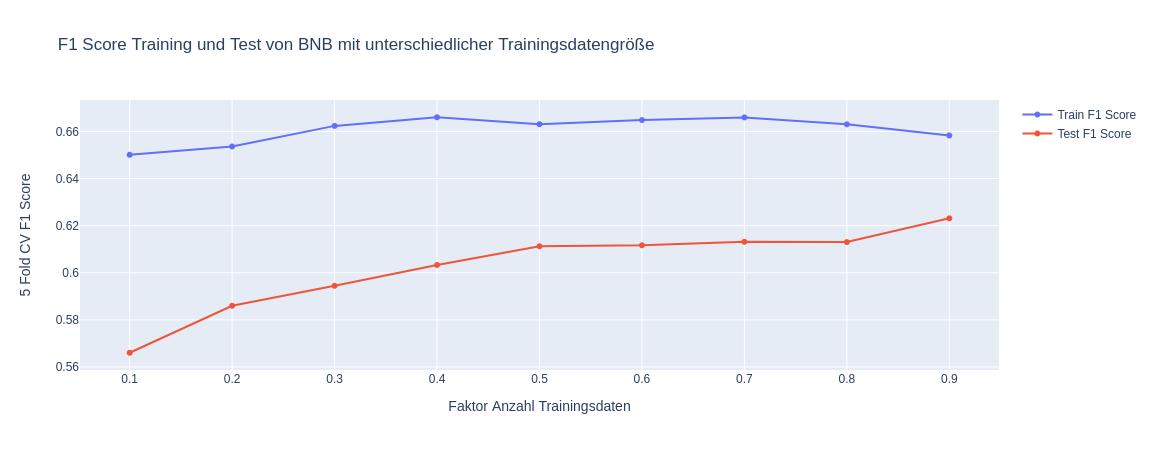

In [36]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

clf = BernoulliNB()

pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="quantile", n_bins=34), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "BNB")

## Random Forest

Best model:
- adasyn
- F1 Score: 0.769
- ROC AUC: 0.985
- Bot AUC: 0.956
- Bot type AUC: 0.952

### Basic

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

clf = RandomForestClassifier(random_state=42, n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

param_grid = {
    "clf__max_depth": range(1, 150, 30),
    "clf__criterion": ["entropy", "gini"],
    "clf__max_features": range(1, X.shape[1], 50)
}

gs = CustomGridSearchCV(pipeline, estimator_params=param_grid)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

- gini
- depth=28
- features=55

F1 Score (macro): 0.761
ROC AUC (macro): 0.972
Human Bot AUC: 0.988
Bot type AUC (macro): 0.989
content
	F1 Score (mean): 0.828
	ROC AUC (mean): 0.991
fake_follower
	F1 Score (mean): 0.868
	ROC AUC (mean): 0.979
feed
	F1 Score (mean): 0.643
	ROC AUC (mean): 0.975
game
	F1 Score (mean): 0.150
	ROC AUC (mean): 0.864
human
	F1 Score (mean): 0.957
	ROC AUC (mean): 0.988
political
	F1 Score (mean): 0.843
	ROC AUC (mean): 0.984
service
	F1 Score (mean): 0.484
	ROC AUC (mean): 0.960
social_spam
	F1 Score (mean): 0.982
	ROC AUC (mean): 0.996
stock
	F1 Score (mean): 0.934
	ROC AUC (mean): 0.994
traditional_spam
	F1 Score (mean): 0.923
	ROC AUC (mean): 0.986


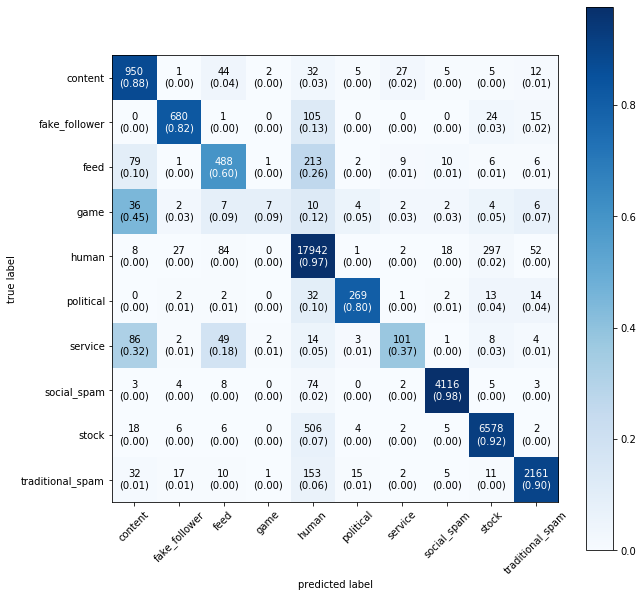

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

clf = RandomForestClassifier(max_depth=28, max_features=55, criterion="gini", random_state=42, n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### oversampling game class

#### adasyn

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

clf = RandomForestClassifier(random_state=42, n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

estimator_params = {
    "clf__max_depth": range(30, 34, 1),
    "clf__criterion": ["entropy"],
    "clf__max_features": range(22, 23, 1)
}

train_preproc_params = {
    "n_neighbors": range(29,30,1),
    "sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names, train_preproc_func=oversampling_adasyn, train_preproc_params=train_preproc_params)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 4
4/4 (avg 62.30s/job)0.7685572607364755
(   {   'clf__criterion': 'entropy',
        'clf__max_depth': 31,
        'clf__max_features': 22},
    {'n_neighbors': 29, 'sampling_strategy': {3: 800}})
{   'bot_aucs': [   0.9572913739814555,
                    0.9558864849676876,
                    0.9593987075021073,
                    0.9544752002248138,
                    0.9533511310945623],
    'bot_type_aucs': [   0.9532171958415285,
                         0.9529362180387749,
                         0.95490306265805,
                         0.9495573977799635,
                         0.9487143459322749],
    'class_scores': {   'content': {   'f1_scores': [   0.8398268398268397,
                                                        0.8170212765957447,
                                                        0.8389830508474576,
                                                        0.800865800865801,
                                                        0.

F1 Score (macro): 0.769
ROC AUC (macro): 0.985
Human Bot AUC: 0.990
Bot type AUC (macro): 0.991
content
	F1 Score (mean): 0.827
	ROC AUC (mean): 0.994
fake_follower
	F1 Score (mean): 0.871
	ROC AUC (mean): 0.982
feed
	F1 Score (mean): 0.655
	ROC AUC (mean): 0.980
game
	F1 Score (mean): 0.206
	ROC AUC (mean): 0.960
human
	F1 Score (mean): 0.958
	ROC AUC (mean): 0.990
political
	F1 Score (mean): 0.840
	ROC AUC (mean): 0.990
service
	F1 Score (mean): 0.476
	ROC AUC (mean): 0.973
social_spam
	F1 Score (mean): 0.985
	ROC AUC (mean): 0.996
stock
	F1 Score (mean): 0.940
	ROC AUC (mean): 0.994
traditional_spam
	F1 Score (mean): 0.928
	ROC AUC (mean): 0.990


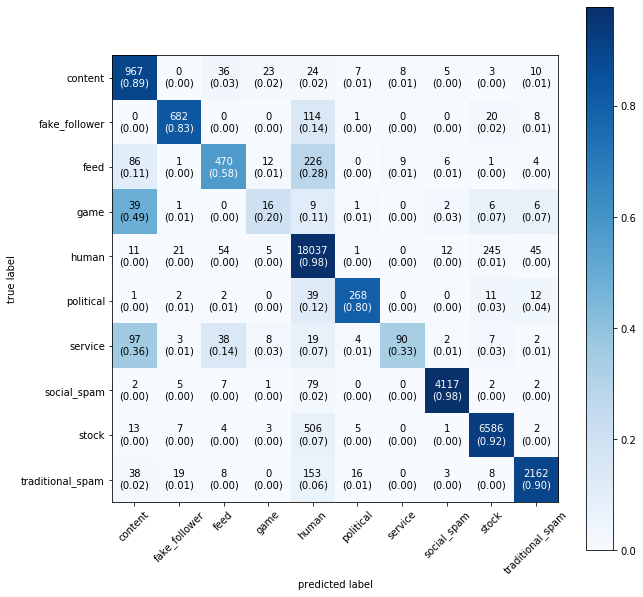

In [36]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

clf = RandomForestClassifier(max_depth=31, max_features=22, criterion="entropy", random_state=42, n_jobs=os.cpu_count())

adasyn = ADASYN(sampling_strategy={3:800}, n_neighbors=29, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("adasyn", adasyn), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### smote

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

clf = RandomForestClassifier(random_state=42, n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

estimator_params = {
    "clf__max_depth": range(25, 35, 1),
    "clf__criterion": ["entropy"],
    "clf__max_features": range(18, 23, 1)
}

train_preproc_params = {
    "k_neighbors": list(range(15,26,1)),
    "sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names, train_preproc_func=oversampling_smote, train_preproc_params=train_preproc_params)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 550
550/550 (avg 168.67s/job)0.7693280779450543
(   {   'clf__criterion': 'entropy',
        'clf__max_depth': 30,
        'clf__max_features': 20},
    {'k_neighbors': 17, 'sampling_strategy': {3: 800}})
{   'bot_aucs': [   0.9577128406855858,
                    0.9571508850800787,
                    0.9574318628828322,
                    0.957425881691724,
                    0.9567233384853169],
    'bot_type_aucs': [   0.9534981736442821,
                         0.9546220848552964,
                         0.9527957291373982,
                         0.9527890965294366,
                         0.9525080792468736],
    'class_scores': {   'content': {   'f1_scores': [   0.8340425531914892,
                                                        0.8205128205128205,
                                                        0.8385744234800839,
                                                        0.8199566160520608,
                                                 

F1 Score (macro): 0.769
ROC AUC (macro): 0.985
Human Bot AUC: 0.990
Bot type AUC (macro): 0.991
content
	F1 Score (mean): 0.832
	ROC AUC (mean): 0.993
fake_follower
	F1 Score (mean): 0.871
	ROC AUC (mean): 0.981
feed
	F1 Score (mean): 0.652
	ROC AUC (mean): 0.984
game
	F1 Score (mean): 0.196
	ROC AUC (mean): 0.958
human
	F1 Score (mean): 0.960
	ROC AUC (mean): 0.990
political
	F1 Score (mean): 0.853
	ROC AUC (mean): 0.991
service
	F1 Score (mean): 0.475
	ROC AUC (mean): 0.973
social_spam
	F1 Score (mean): 0.985
	ROC AUC (mean): 0.996
stock
	F1 Score (mean): 0.941
	ROC AUC (mean): 0.994
traditional_spam
	F1 Score (mean): 0.929
	ROC AUC (mean): 0.989


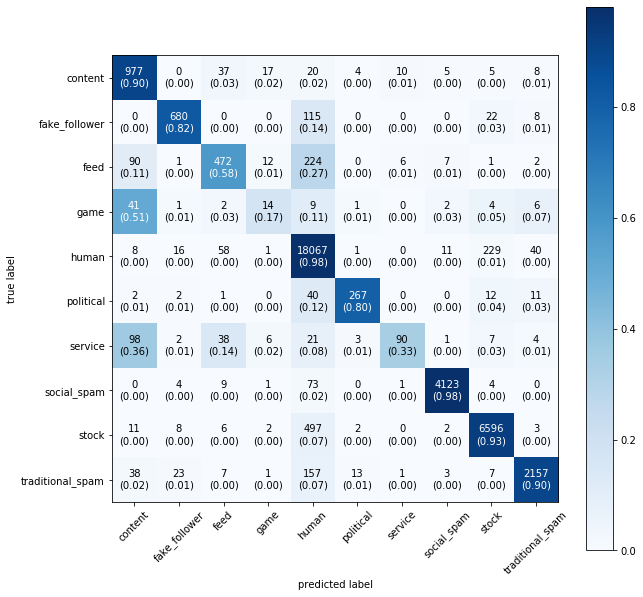

In [39]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

clf = RandomForestClassifier(max_depth=30, max_features=20, criterion="entropy", random_state=42, n_jobs=os.cpu_count())

smote = SMOTE(sampling_strategy={3:800}, k_neighbors=17, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("smote", smote), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### Feature importance

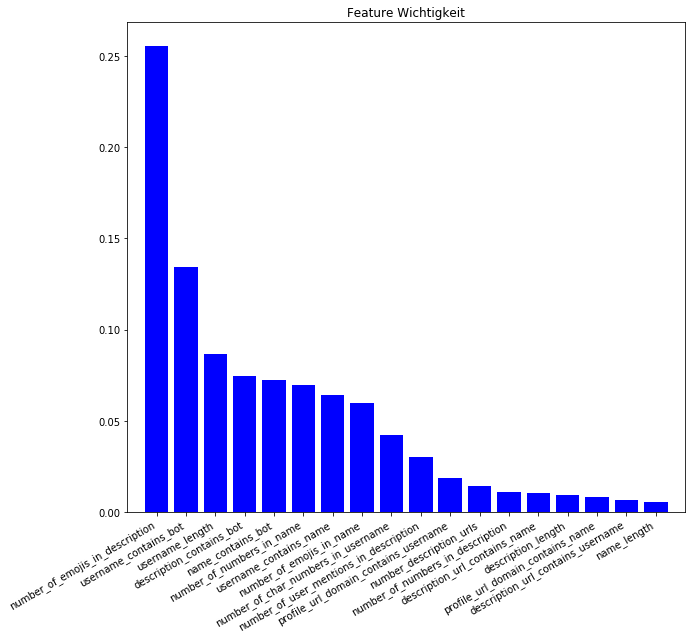

In [21]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

clf = RandomForestClassifier(max_depth=31, max_features=22, criterion="entropy", random_state=42, n_jobs=os.cpu_count())

smote = ADASYN(sampling_strategy={3:800}, n_neighbors=29, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("smote", smote), ("clf", clf)])

pipeline.fit(X, y)


importances = clf.feature_importances_
importances = importances[np.argwhere(importances > 0.005)].reshape(1,-1)[0]
indices = np.argsort(importances)[::-1]

f_names = np.asarray(user_features_index)

fig = plt.figure(figsize=(10,10))

plt.title("Feature Wichtigkeit")
plt.bar(f_names[indices], importances[indices],
       color="b", align="center")
plt.xlim([-1, importances.shape[0]])
fig.autofmt_xdate()
plt.show()

### different train sizes

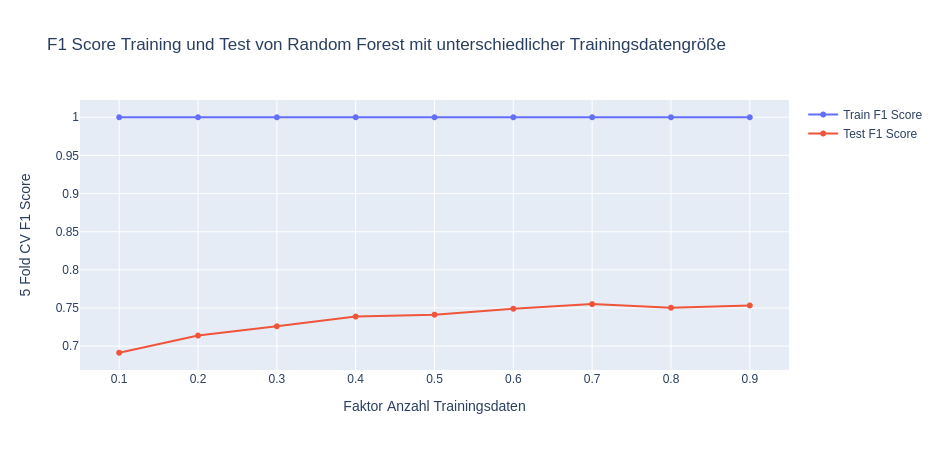

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

clf = RandomForestClassifier(max_depth=28, max_features=55, criterion="gini", random_state=42, n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "Random Forest")

## Decision Tree

Best model:
- smote
- F1 Score: 0.714
- ROC AUC: 0.922
- Bot AUC: 0.943
- Bot type AUC: 0.935

### Basic

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier(random_state=42)
pipeline = Pipeline([("clf", clf)])

estimator_params = {
    "clf__max_depth": range(1,15, 1),
    "clf__criterion": ["entropy"],
    "clf__max_features": range(1,50,1)
}

gs = CustomGridSearchCV(pipeline, params=estimator_params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

- max_depth: 10
- max_features: 43
- criterion: entropy

F1 Score (macro): 0.698
ROC AUC (macro): 0.899
Human Bot AUC: 0.970
Bot type AUC (macro): 0.963
content
	F1 Score (mean): 0.774
	ROC AUC (mean): 0.940
fake_follower
	F1 Score (mean): 0.802
	ROC AUC (mean): 0.925
feed
	F1 Score (mean): 0.551
	ROC AUC (mean): 0.885
game
	F1 Score (mean): 0.015
	ROC AUC (mean): 0.632
human
	F1 Score (mean): 0.946
	ROC AUC (mean): 0.970
political
	F1 Score (mean): 0.748
	ROC AUC (mean): 0.918
service
	F1 Score (mean): 0.357
	ROC AUC (mean): 0.798
social_spam
	F1 Score (mean): 0.975
	ROC AUC (mean): 0.991
stock
	F1 Score (mean): 0.917
	ROC AUC (mean): 0.979
traditional_spam
	F1 Score (mean): 0.897
	ROC AUC (mean): 0.955


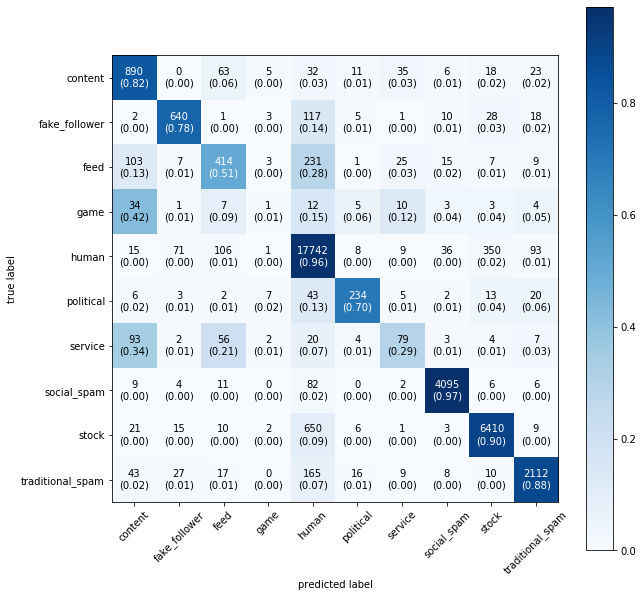

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier(max_depth=10, criterion="entropy", max_features=43)
pipeline = Pipeline([("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### oversampling game class

#### adasyn

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier()
pipeline = Pipeline([("clf", clf)])

estimator_params = {
    "clf__max_depth": range(1, 150, 30),
    "clf__criterion": ["entropy", "gini"],
    "clf__max_features": range(1, X.shape[1] + 1, 10)
}

train_preproc_params = {
    "n_neighbors": list(range(1,61,10)),
    "sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names, train_preproc_func=oversampling_adasyn, train_preproc_params=train_preproc_params)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

F1 Score (macro): 0.699
ROC AUC (macro): 0.917
Human Bot AUC: 0.970
Bot type AUC (macro): 0.965
content
	F1 Score (mean): 0.766
	ROC AUC (mean): 0.960
fake_follower
	F1 Score (mean): 0.806
	ROC AUC (mean): 0.934
feed
	F1 Score (mean): 0.535
	ROC AUC (mean): 0.896
game
	F1 Score (mean): 0.089
	ROC AUC (mean): 0.736
human
	F1 Score (mean): 0.944
	ROC AUC (mean): 0.970
political
	F1 Score (mean): 0.729
	ROC AUC (mean): 0.914
service
	F1 Score (mean): 0.340
	ROC AUC (mean): 0.836
social_spam
	F1 Score (mean): 0.973
	ROC AUC (mean): 0.992
stock
	F1 Score (mean): 0.915
	ROC AUC (mean): 0.979
traditional_spam
	F1 Score (mean): 0.897
	ROC AUC (mean): 0.952


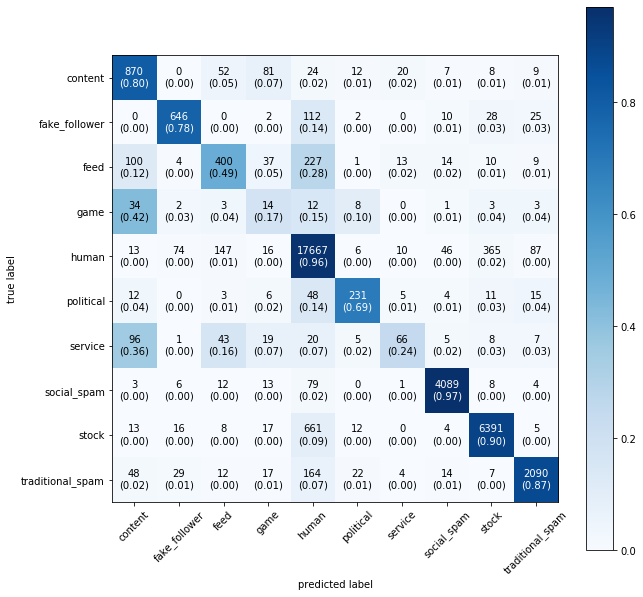

In [41]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

clf = DecisionTreeClassifier(max_depth=10, criterion="entropy", max_features=46, random_state=42)

adasyn = ADASYN(sampling_strategy={3:800}, n_neighbors=48, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("adasyn", adasyn), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### smote

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier(random_state=42)
pipeline = Pipeline([("clf", clf)])

estimator_params = {
    "clf__max_depth": range(1, 150, 30),
    "clf__criterion": ["entropy", "gini"],
    "clf__max_features": range(1, X.shape[1] + 1, 10)
}

train_preproc_params = {
    "k_neighbors": list(range(1,61,10)),
    "sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names, train_preproc_func=oversampling_smote, train_preproc_params=train_preproc_params)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

F1 Score (macro): 0.714
ROC AUC (macro): 0.922
Human Bot AUC: 0.971
Bot type AUC (macro): 0.967
content
	F1 Score (mean): 0.779
	ROC AUC (mean): 0.960
fake_follower
	F1 Score (mean): 0.812
	ROC AUC (mean): 0.936
feed
	F1 Score (mean): 0.531
	ROC AUC (mean): 0.889
game
	F1 Score (mean): 0.145
	ROC AUC (mean): 0.755
human
	F1 Score (mean): 0.946
	ROC AUC (mean): 0.971
political
	F1 Score (mean): 0.743
	ROC AUC (mean): 0.905
service
	F1 Score (mean): 0.393
	ROC AUC (mean): 0.877
social_spam
	F1 Score (mean): 0.970
	ROC AUC (mean): 0.991
stock
	F1 Score (mean): 0.918
	ROC AUC (mean): 0.979
traditional_spam
	F1 Score (mean): 0.899
	ROC AUC (mean): 0.957


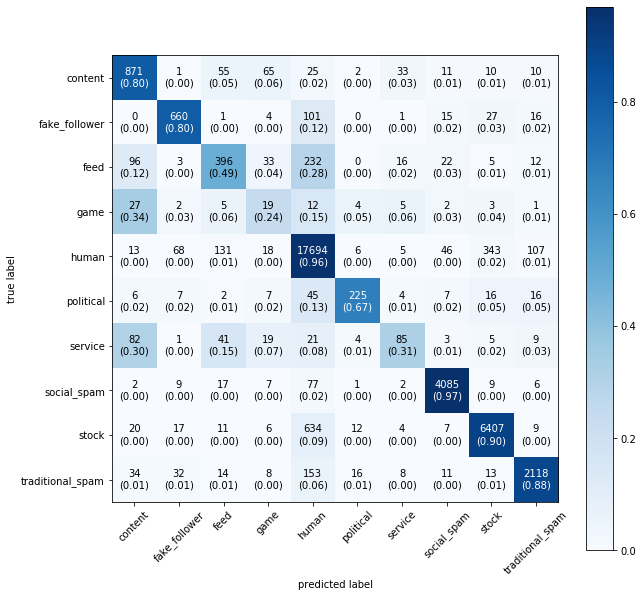

In [42]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

clf = DecisionTreeClassifier(max_depth=10, criterion="entropy", max_features=43, random_state=42)

smote = SMOTE(sampling_strategy={3:800}, k_neighbors=39, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("smote", smote), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### Feature importance

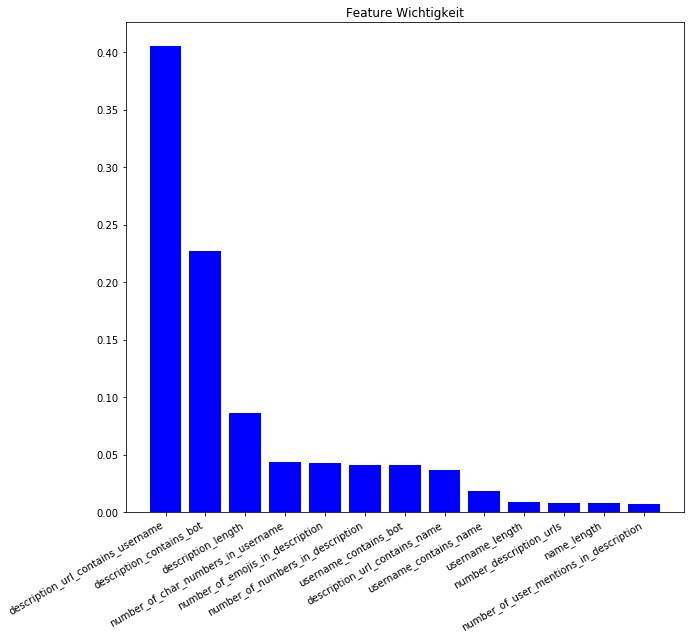

In [41]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

clf = DecisionTreeClassifier(max_depth=10, criterion="entropy", max_features=43, random_state=42)

smote = SMOTE(sampling_strategy={3:800}, k_neighbors=39, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("smote", smote), ("clf", clf)])

pipeline.fit(X, y)

importances = clf.feature_importances_
importances = importances[np.argwhere(importances > 0.005)].reshape(1,-1)[0]
indices = np.argsort(importances)[::-1]

f_names = np.asarray(user_features_index)

fig = plt.figure(figsize=(10,10))

plt.title("Feature Wichtigkeit")
plt.bar(f_names[indices], importances[indices],
       color="b", align="center")
plt.xlim([-1, importances.shape[0]])
fig.autofmt_xdate()
plt.show()

### different train sizes

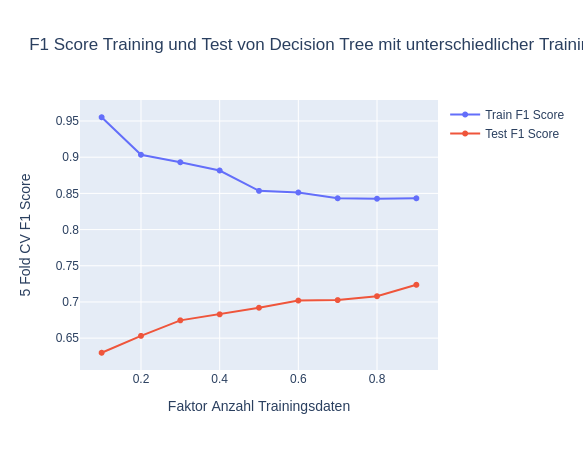

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier(max_depth=10, criterion="entropy", max_features=43)
pipeline = Pipeline([("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "Decision Tree")

## Deep Neuronal Network

Best Models:


### Basic

scale values between 0 and 1

Restoring model weights from the end of the best epoch.
Epoch 00233: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00158: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00323: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00247: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00363: early stopping
F1 Score (macro): 0.649
ROC AUC (macro): 0.973
Human Bot AUC: 0.973
Bot type AUC (macro): 0.976
LOG LOSS (mean): 0.380
content
	F1 Score (mean): 0.790
	ROC AUC (mean): 0.989
fake_follower
	F1 Score (mean): 0.687
	ROC AUC (mean): 0.974
feed
	F1 Score (mean): 0.534
	ROC AUC (mean): 0.967
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.934
human
	F1 Score (mean): 0.922
	ROC AUC (mean): 0.973
political
	F1 Score (mean): 0.522
	ROC AUC (mean): 0.975
service
	F1 Score (mean): 0.390
	ROC AUC (mean): 0.961
social_spam
	F1 Score (mean): 0.971
	ROC AUC (mean): 0.997
stock
	F1 Score (

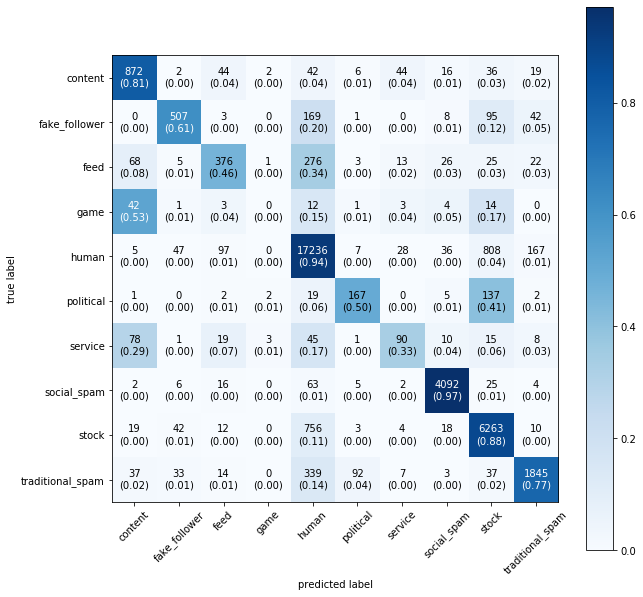

In [19]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

scores = {"f1_scores": [], "roc_auc_macro": [], "confusion_matrices": [], "bot_aucs": [], "bot_type_aucs": [],
              "class_scores": {}, "fpr_macro": [], "tpr_macro": [], "log_loss": []}

for l in label_names:
    scores["class_scores"][l] = {
        "f1_scores": [],
        "roc_aucs": [],
        "fpr": [],
        "tpr": []
    }


for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_min_max, y):
    f1_scores = []

    X_train, X_test = X_min_max[train_index], X_min_max[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = tf.keras.models.clone_model(model)
    
    model.compile(
      optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"]
    )

    model.fit(X_train,
      y_train,
      epochs=800,
      batch_size=64,
      callbacks=[es],
      verbose=0)
    
    y_pred_prob = model.predict_proba(X_test)

    y_true = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

    fpr = dict()
    tpr = dict()
    roc_aucs = dict()
    for i, l in enumerate(label_names):
        fpr[l], tpr[l], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_aucs[l] = auc(fpr[l], tpr[l])

    all_fpr = np.unique(np.concatenate([fpr[l] for l in label_names]))

    mean_tpr = np.zeros_like(all_fpr)
    for l in label_names:
        mean_tpr += np.interp(all_fpr, fpr[l], tpr[l])

    mean_tpr /= len(label_names)
        
    scores["fpr_macro"] = all_fpr
    scores["tpr_macro"] = mean_tpr

    y_pred = np.argmax(y_pred_prob, axis=1)

    f1_scores = f1_score(y_test, y_pred, average=None)
        
    mean_fpr = np.linspace(0, 1, 10)

    for i, l in enumerate(label_names):
        scores["class_scores"][l]["f1_scores"].append(f1_scores[i])
        scores["class_scores"][l]["roc_aucs"].append(roc_aucs[l])
            
        scores["class_scores"][l]["fpr"].append(fpr[l])
        scores["class_scores"][l]["tpr"].append(tpr[l])            

    scores["f1_scores"].append(np.mean(f1_scores))
    scores["roc_auc_macro"].append(auc(all_fpr, mean_tpr))
    scores["confusion_matrices"].append(confusion_matrix(y_test, y_pred))

    scores["log_loss"].append(log_loss(y_test, y_pred_prob, eps=1e-15))

    y_test_2 = np.copy(y_test)
    y_test_2[y_test_2 != label_names.index("human")] = -1
        
    # column 0: bot
    # column 1: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()
        
    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 2))
        
    y_pred_prob_2[:,1] = y_pred_prob[:,label_names.index("human")]
        
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n != "human"]].sum(axis=1)
        
    scores["bot_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2))

    y_test_2 = np.copy(y_test)
    # good bots
    y_test_2[y_test_2 == label_names.index("content")] = -2
    y_test_2[y_test_2 == label_names.index("feed")] = -2
    y_test_2[y_test_2 == label_names.index("game")] = -2
    y_test_2[y_test_2 == label_names.index("service")] = -2
    # bad bots
    y_test_2[y_test_2 == label_names.index("fake_follower")] = -1
    y_test_2[y_test_2 == label_names.index("political")] = -1
    y_test_2[y_test_2 == label_names.index("social_spam")] = -1
    y_test_2[y_test_2 == label_names.index("stock")] = -1
    y_test_2[y_test_2 == label_names.index("traditional_spam")] = -1
        
    # column 0: good bot
    # column 1: bad bot
    # column 2: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()

    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 3))
    # good bots
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["content", "feed", "game", "service"]]].sum(axis=1)
    # bad bots
    y_pred_prob_2[:,1] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["fake_follower", "political", "social_spam", "stock", "traditional_spam"]]].sum(axis=1)
        
    y_pred_prob_2[:,2] = y_pred_prob[:,label_names.index("human")]
                                                         
    scores["bot_type_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2, average="macro", multi_class="ovr"))

print_eval(scores, label_names, console_confm_print=False)

### Oversampling game class

#### adasyn

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

res = []

for i in range(1,17,2):

    for train_index, test_index in StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X_min_max, y):
        f1_scores = []

        X_train, X_test = X_min_max[train_index], X_min_max[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train, y_train = oversampling_adasyn(X_train, y_train, {"n_neighbors" : i, "sampling_strategy": {3:800}})

        model = tf.keras.models.clone_model(model)

        model.compile(
            optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
            loss="sparse_categorical_crossentropy",
            metrics=["sparse_categorical_accuracy"]
        )

        model.fit(
            X_train,
            y_train,
            epochs=800,
            batch_size=64,
            callbacks=[es],
            verbose=0
        )

        y_pred_prob = model.predict_proba(X_test)
        
        y_pred = np.argmax(y_pred_prob, axis=1)

        f1_scores = f1_score(y_test, y_pred, average=None)

        res.append((i, f1_scores))

r = {}
for i in res:
    if i[0] in r:
        r[i[0]].append(np.mean(i[1]))
    else:
        r[i[0]] = [np.mean(i[1])]
    
for i, f in r.items():
    print(i, np.mean(f))

best:
 - k_neighbors: 10
 - sampling_strategy: 800

Restoring model weights from the end of the best epoch.
Epoch 00240: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00197: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00280: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00204: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00249: early stopping
F1 Score (macro): 0.652
ROC AUC (macro): 0.962
Human Bot AUC: 0.972
Bot type AUC (macro): 0.975
LOG LOSS (mean): 0.402
content
	F1 Score (mean): 0.764
	ROC AUC (mean): 0.988
fake_follower
	F1 Score (mean): 0.661
	ROC AUC (mean): 0.973
feed
	F1 Score (mean): 0.506
	ROC AUC (mean): 0.963
game
	F1 Score (mean): 0.075
	ROC AUC (mean): 0.835
human
	F1 Score (mean): 0.921
	ROC AUC (mean): 0.972
political
	F1 Score (mean): 0.564
	ROC AUC (mean): 0.979
service
	F1 Score (mean): 0.397
	ROC AUC (mean): 0.957
social_spam
	F1 Score (mean): 0.969
	ROC AUC (mean): 0.997
stock
	F1 Score (

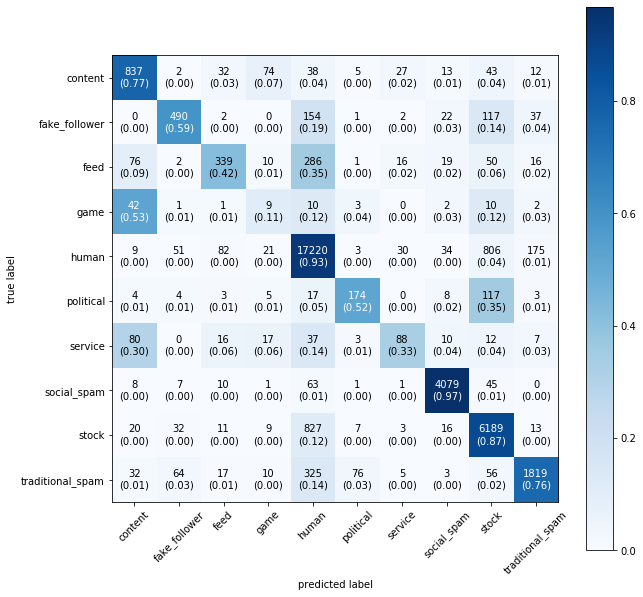

In [20]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

scores = {"f1_scores": [], "roc_auc_macro": [], "confusion_matrices": [], "bot_aucs": [], "bot_type_aucs": [],
              "class_scores": {}, "fpr_macro": [], "tpr_macro": [], "log_loss": []}

for l in label_names:
    scores["class_scores"][l] = {
        "f1_scores": [],
        "roc_aucs": [],
        "fpr": [],
        "tpr": []
    }


for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_min_max, y):
    f1_scores = []

    X_train, X_test = X_min_max[train_index], X_min_max[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train, y_train = oversampling_adasyn(X_train, y_train, {"n_neighbors": 10 , "sampling_strategy": {3:800}})
    
    model = tf.keras.models.clone_model(model)
    
    model.compile(
      optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"]
    )

    model.fit(X_train,
      y_train,
      epochs=800,
      batch_size=64,
      callbacks=[es],
      verbose=0)
    
    y_pred_prob = model.predict_proba(X_test)

    y_true = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

    fpr = dict()
    tpr = dict()
    roc_aucs = dict()
    for i, l in enumerate(label_names):
        fpr[l], tpr[l], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_aucs[l] = auc(fpr[l], tpr[l])

    all_fpr = np.unique(np.concatenate([fpr[l] for l in label_names]))

    mean_tpr = np.zeros_like(all_fpr)
    for l in label_names:
        mean_tpr += np.interp(all_fpr, fpr[l], tpr[l])

    mean_tpr /= len(label_names)
        
    scores["fpr_macro"] = all_fpr
    scores["tpr_macro"] = mean_tpr

    y_pred = np.argmax(y_pred_prob, axis=1)

    f1_scores = f1_score(y_test, y_pred, average=None)
        
    mean_fpr = np.linspace(0, 1, 10)

    for i, l in enumerate(label_names):
        scores["class_scores"][l]["f1_scores"].append(f1_scores[i])
        scores["class_scores"][l]["roc_aucs"].append(roc_aucs[l])
            
        scores["class_scores"][l]["fpr"].append(fpr[l])
        scores["class_scores"][l]["tpr"].append(tpr[l])            

    scores["f1_scores"].append(np.mean(f1_scores))
    scores["roc_auc_macro"].append(auc(all_fpr, mean_tpr))
    scores["confusion_matrices"].append(confusion_matrix(y_test, y_pred))

    scores["log_loss"].append(log_loss(y_test, y_pred_prob, eps=1e-15))

    y_test_2 = np.copy(y_test)
    y_test_2[y_test_2 != label_names.index("human")] = -1
        
    # column 0: bot
    # column 1: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()
        
    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 2))
        
    y_pred_prob_2[:,1] = y_pred_prob[:,label_names.index("human")]
        
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n != "human"]].sum(axis=1)
        
    scores["bot_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2))

    y_test_2 = np.copy(y_test)
    # good bots
    y_test_2[y_test_2 == label_names.index("content")] = -2
    y_test_2[y_test_2 == label_names.index("feed")] = -2
    y_test_2[y_test_2 == label_names.index("game")] = -2
    y_test_2[y_test_2 == label_names.index("service")] = -2
    # bad bots
    y_test_2[y_test_2 == label_names.index("fake_follower")] = -1
    y_test_2[y_test_2 == label_names.index("political")] = -1
    y_test_2[y_test_2 == label_names.index("social_spam")] = -1
    y_test_2[y_test_2 == label_names.index("stock")] = -1
    y_test_2[y_test_2 == label_names.index("traditional_spam")] = -1
        
    # column 0: good bot
    # column 1: bad bot
    # column 2: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()

    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 3))
    # good bots
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["content", "feed", "game", "service"]]].sum(axis=1)
    # bad bots
    y_pred_prob_2[:,1] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["fake_follower", "political", "social_spam", "stock", "traditional_spam"]]].sum(axis=1)
        
    y_pred_prob_2[:,2] = y_pred_prob[:,label_names.index("human")]
                                                         
    scores["bot_type_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2, average="macro", multi_class="ovr"))

print_eval(scores, label_names, console_confm_print=False)

#### smote

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

res = []

for i in range(1,17,2):

    for train_index, test_index in StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X_min_max, y):
        f1_scores = []

        X_train, X_test = X_min_max[train_index], X_min_max[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train, y_train = oversampling_smote(X_train, y_train, {"k_neighbors" : i, "sampling_strategy": {3:800}})

        model = tf.keras.models.clone_model(model)

        model.compile(
            optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
            loss="sparse_categorical_crossentropy",
            metrics=["sparse_categorical_accuracy"]
        )

        model.fit(
            X_train,
            y_train,
            epochs=800,
            batch_size=64,
            callbacks=[es],
            verbose=0
        )

        y_pred_prob = model.predict_proba(X_test)
        
        y_pred = np.argmax(y_pred_prob, axis=1)

        f1_scores = f1_score(y_test, y_pred, average=None)

        res.append((i, f1_scores))

r = {}
for i in res:
    if i[0] in r:
        r[i[0]].append(np.mean(i[1]))
    else:
        r[i[0]] = [np.mean(i[1])]
    
for i, f in r.items():
    print(i, np.mean(f))

best:
 - k_neighbors: 3
 - sampling_strategy: 800

Restoring model weights from the end of the best epoch.
Epoch 00175: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00184: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00274: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00318: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00299: early stopping
F1 Score (macro): 0.647
ROC AUC (macro): 0.956
Human Bot AUC: 0.971
Bot type AUC (macro): 0.974
LOG LOSS (mean): 0.416
content
	F1 Score (mean): 0.755
	ROC AUC (mean): 0.986
fake_follower
	F1 Score (mean): 0.651
	ROC AUC (mean): 0.968
feed
	F1 Score (mean): 0.510
	ROC AUC (mean): 0.961
game
	F1 Score (mean): 0.066
	ROC AUC (mean): 0.789
human
	F1 Score (mean): 0.920
	ROC AUC (mean): 0.971
political
	F1 Score (mean): 0.566
	ROC AUC (mean): 0.975
service
	F1 Score (mean): 0.374
	ROC AUC (mean): 0.959
social_spam
	F1 Score (mean): 0.962
	ROC AUC (mean): 0.997
stock
	F1 Score (

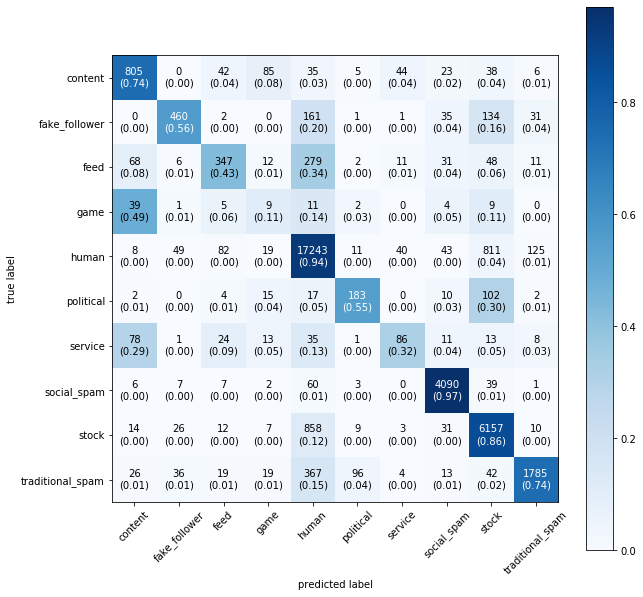

In [21]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

scores = {"f1_scores": [], "roc_auc_macro": [], "confusion_matrices": [], "bot_aucs": [], "bot_type_aucs": [],
              "class_scores": {}, "fpr_macro": [], "tpr_macro": [], "log_loss": []}

for l in label_names:
    scores["class_scores"][l] = {
        "f1_scores": [],
        "roc_aucs": [],
        "fpr": [],
        "tpr": []
    }


for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_min_max, y):
    f1_scores = []

    X_train, X_test = X_min_max[train_index], X_min_max[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train, y_train = oversampling_smote(X_train, y_train, {"k_neighbors" : 3, "sampling_strategy": {3:800}})
    
    model = tf.keras.models.clone_model(model)
    
    model.compile(
      optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"]
    )

    model.fit(X_train,
      y_train,
      epochs=800,
      batch_size=64,
      callbacks=[es],
      verbose=0)
    
    y_pred_prob = model.predict_proba(X_test)

    y_true = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

    fpr = dict()
    tpr = dict()
    roc_aucs = dict()
    for i, l in enumerate(label_names):
        fpr[l], tpr[l], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_aucs[l] = auc(fpr[l], tpr[l])

    all_fpr = np.unique(np.concatenate([fpr[l] for l in label_names]))

    mean_tpr = np.zeros_like(all_fpr)
    for l in label_names:
        mean_tpr += np.interp(all_fpr, fpr[l], tpr[l])

    mean_tpr /= len(label_names)
        
    scores["fpr_macro"] = all_fpr
    scores["tpr_macro"] = mean_tpr

    y_pred = np.argmax(y_pred_prob, axis=1)

    f1_scores = f1_score(y_test, y_pred, average=None)
        
    mean_fpr = np.linspace(0, 1, 10)

    for i, l in enumerate(label_names):
        scores["class_scores"][l]["f1_scores"].append(f1_scores[i])
        scores["class_scores"][l]["roc_aucs"].append(roc_aucs[l])
            
        scores["class_scores"][l]["fpr"].append(fpr[l])
        scores["class_scores"][l]["tpr"].append(tpr[l])            

    scores["f1_scores"].append(np.mean(f1_scores))
    scores["roc_auc_macro"].append(auc(all_fpr, mean_tpr))
    scores["confusion_matrices"].append(confusion_matrix(y_test, y_pred))

    scores["log_loss"].append(log_loss(y_test, y_pred_prob, eps=1e-15))

    y_test_2 = np.copy(y_test)
    y_test_2[y_test_2 != label_names.index("human")] = -1
        
    # column 0: bot
    # column 1: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()
        
    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 2))
        
    y_pred_prob_2[:,1] = y_pred_prob[:,label_names.index("human")]
        
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n != "human"]].sum(axis=1)
        
    scores["bot_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2))

    y_test_2 = np.copy(y_test)
    # good bots
    y_test_2[y_test_2 == label_names.index("content")] = -2
    y_test_2[y_test_2 == label_names.index("feed")] = -2
    y_test_2[y_test_2 == label_names.index("game")] = -2
    y_test_2[y_test_2 == label_names.index("service")] = -2
    # bad bots
    y_test_2[y_test_2 == label_names.index("fake_follower")] = -1
    y_test_2[y_test_2 == label_names.index("political")] = -1
    y_test_2[y_test_2 == label_names.index("social_spam")] = -1
    y_test_2[y_test_2 == label_names.index("stock")] = -1
    y_test_2[y_test_2 == label_names.index("traditional_spam")] = -1
        
    # column 0: good bot
    # column 1: bad bot
    # column 2: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()

    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 3))
    # good bots
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["content", "feed", "game", "service"]]].sum(axis=1)
    # bad bots
    y_pred_prob_2[:,1] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["fake_follower", "political", "social_spam", "stock", "traditional_spam"]]].sum(axis=1)
        
    y_pred_prob_2[:,2] = y_pred_prob[:,label_names.index("human")]
                                                         
    scores["bot_type_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2, average="macro", multi_class="ovr"))

print_eval(scores, label_names, console_confm_print=False)

### different train sizes

Restoring model weights from the end of the best epoch.
Epoch 00154: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00131: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00152: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00245: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00173: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00167: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00255: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00152: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00196: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00236: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00174: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00185: early s

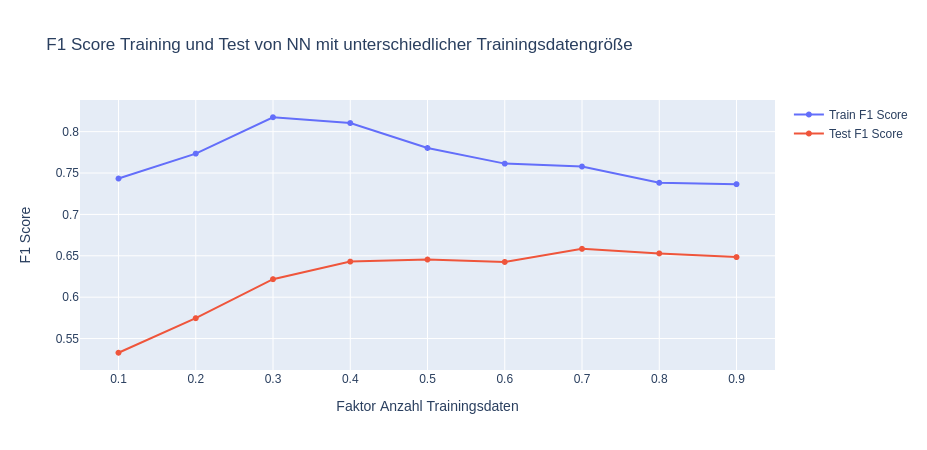

In [91]:
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

train_sizes = []
train_scores_mean = []
test_scores_mean = []

train_size_factors = np.linspace(0.1, 0.9, 9)

for size in train_size_factors:
    
    train_sizes.append(int(X.shape[0] * size))
    
    test_scores_fold = []
    train_scores_fold = []

    for train_index, test_index in StratifiedShuffleSplit(n_splits=5, train_size=size, random_state=42).split(X_min_max, y):
        f1_scores = []

        X_train, X_test = X_min_max[train_index], X_min_max[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = tf.keras.models.clone_model(model)

        model.compile(
          optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
          loss="sparse_categorical_crossentropy",
          metrics=["sparse_categorical_accuracy"]
        )

        model.fit(X_train,
          y_train,
          epochs=800,
          batch_size=64,
          callbacks=[es],
          verbose=0)

        y_pred_prob = model.predict_proba(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        test_scores_fold.append(np.mean(f1_score(y_test, y_pred, average=None)))
        
        y_pred_prob = model.predict_proba(X_train)
        y_pred = np.argmax(y_pred_prob, axis=1)
        train_scores_fold.append(np.mean(f1_score(y_train, y_pred, average=None)))

    test_scores_mean.append(np.mean(test_scores_fold))
    train_scores_mean.append(np.mean(train_scores_fold))
    
fig = go.Figure(data=[
    go.Scatter(x=train_size_factors, y=train_scores_mean, name="Train F1 Score"),
    go.Scatter(x=train_size_factors, y=test_scores_mean, name="Test F1 Score"),
])
fig.update_layout(title="F1 Score Training und Test von NN mit unterschiedlicher Trainingsdatengröße",
                   xaxis_title="Faktor Anzahl Trainingsdaten",
                   yaxis_title="F1 Score")
fig.show()